### 这是一个关于Pyautogalaxy的学习笔记
 - 本笔记位于 http://cluster.shao.ac.cn/~shen/Lecture/autogalaxy.ipynb
 - autogalaxy 是一个state-of-art的基于Python3.8以上的星系图像仿真，形态和结构分析软件套件 （还可以用于引力透镜建模）
 - 完整的说明文档 https://pyautogalaxy.readthedocs.io/en/latest/
 - 优秀的学习教程：https://github.com/Jammy2211/autogalaxy_workspace
 - 面向对象设计


### 准备一些数据文件:  原始图片，噪声信息，psf

<class 'numpy.ndarray'>
(100, 100)


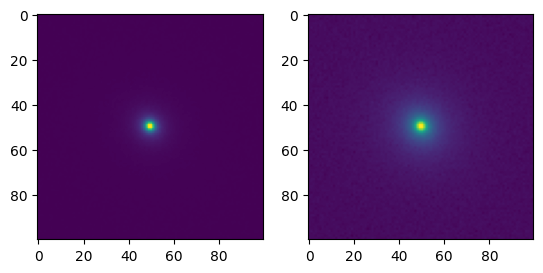

In [4]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# prepare data: read some fits files
filepath = '/home/shen/Python/autogalaxy/dataset/imaging/light_sersic/'
image_data=fits.open(filepath+'image.fits')[0].data.astype('float')
noise_data=fits.open(filepath+'noise_map.fits')[0].data.astype('float')

print(type(image_data))
print(image_data.shape)
plt.subplot(121)
plt.imshow(image_data)
plt.subplot(122)
plt.imshow(noise_data)



#### autogalaxy中的对象
- array_2d: 适配于图像数据的二维数组,额外包含了pixel scale信息，因此图像的分辨单位是角秒
    - 可以执行mask操作 
    - array_2d.native: 原始的二维形式
    - 支持numpy操作
    - 提供一种数据的一维表达（不包含mask数据，从而节省计算资源）
    - 坑：不支持float64类型


In [5]:
import autogalaxy as ag
import autogalaxy.plot as aplt
import autoarray as aa

ima_2d = aa.Array2D.no_mask(values=image_data,shape_native=image_data.shape,pixel_scales=0.1)
noise_2d = aa.Array2D.no_mask(values=noise_data,shape_native=noise_data.shape,pixel_scales=0.1)
print(type(ima_2d))

<class 'autoarray.structures.arrays.uniform_2d.Array2D'>


- Kernel_2d: 描述PSF的二维数组，N*N，N必须是奇数

In [6]:
psf_2d = ag.Kernel2D.from_gaussian(shape_native=(5, 5), sigma=1.5, pixel_scales=0.1) #must be odd
print(type(psf_2d))

<class 'autoarray.structures.arrays.kernel_2d.Kernel2D'>


  - Mask_2d: 用于描述图像mask的二维布尔数组，True是指被Mask

In [7]:
sel=np.where(image_data < 0 ) ### 图像中数值小于0的点被mask
mask_arr=np.zeros(image_data.shape,dtype=bool)
mask_arr[sel]='True'
mask_2d = aa.Mask2D(mask=mask_arr,shape_native=image_data.shape,pixel_scales=0.1)
print(type(mask_2d))

<class 'autoarray.mask.mask_2d.Mask2D'>


- imaging对象，由一个图像数据和噪声数据的arrary_2D对象组装而成,psf对象可选
    - 可以对图像对象进行mask操作

In [8]:
imaging = ag.Imaging(image=ima_2d, noise_map=noise_2d, psf=psf_2d)
imaging = imaging.apply_mask(mask=mask_2d)

2023-02-24 12:35:39,215 - autoarray.dataset.imaging.imaging - INFO - The image and noise map of the `Imaging` objected have been padded to the dimensions(8557,). This is because the blurring region around the mask (which defines wherePSF flux may be convolved into the masked region) extended beyond the edge of the image.This can be prevented by using a smaller mask, smaller PSF kernel size or manually paddingthe image and noise-map yourself.
2023-02-24 12:35:39,219 - autoarray.dataset.imaging.imaging - INFO - IMAGING - Data masked, contains a total of 8557 image-pixels


- 图像对象可以用imageplotter方法进行方便的可视化
- 图像可视化设置可简单调整


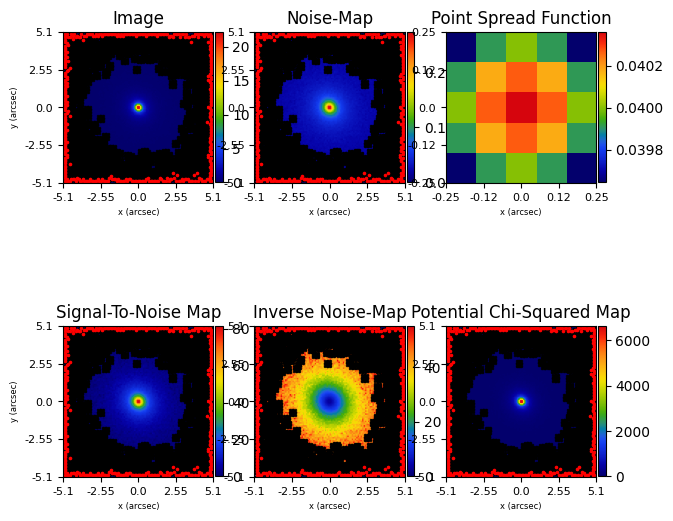

In [9]:
mat_plot_2d = aplt.MatPlot2D(
    figure=aplt.Figure(figsize=(7, 7)),
    yticks=aplt.YTicks(fontsize=8),
    xticks=aplt.XTicks(fontsize=8),
    title=aplt.Title(fontsize=12),
    ylabel=aplt.YLabel(fontsize=6),
    xlabel=aplt.XLabel(fontsize=6),
)
imaging_plotter = aplt.ImagingPlotter(imaging=imaging,mat_plot_2d=mat_plot_2d)
#imaging_plotter.figures_2d(image=True,noise_map=True,psf=True)
imaging_plotter.subplot_imaging()

- galaxy： 星系对象：由核球、盘、clump等线性成份构成，红移三个要素构成
    - 核球、盘、Clump（可以多个）：由lightprofile 对象生成
    - 可以只有bulge或者disk等某一个成份
    - 物理模型，无限分辨率和尺度
    - 红移的作用？（猜测与引力透镜模型相关功能有关）
- lightprofile：轮廓（profile）对象
    - 多种形式： Gaussian，Sersic，chameleon，NFW。。。。
    - 是否可以定制？


In [10]:
bulge = ag.lp.Sersic(
    centre=(0.0, 0.0),
    ell_comps=ag.convert.ell_comps_from(axis_ratio=0.9, angle=45.0),
    intensity=1.0,
    effective_radius=0.6,
    sersic_index=3.0,
)

disk = ag.lp.Exponential(
    centre=(0.0, 0.0),
    ell_comps=ag.convert.ell_comps_from(axis_ratio=0.7, angle=30.0),
    intensity=0.5,
    effective_radius=1.6,
)

galaxy = ag.Galaxy(redshift=0.5, bulge=bulge, disk=disk)

print(type(disk))
print(type(galaxy))

<class 'autogalaxy.profiles.light.standard.exponential.Exponential'>
<class 'autogalaxy.galaxy.galaxy.Galaxy'>


### Grid_2D, 网格对象
    - 星系对象在网格上才能生成相应图片
    - 可以对网格进行旋转变形等线性操作

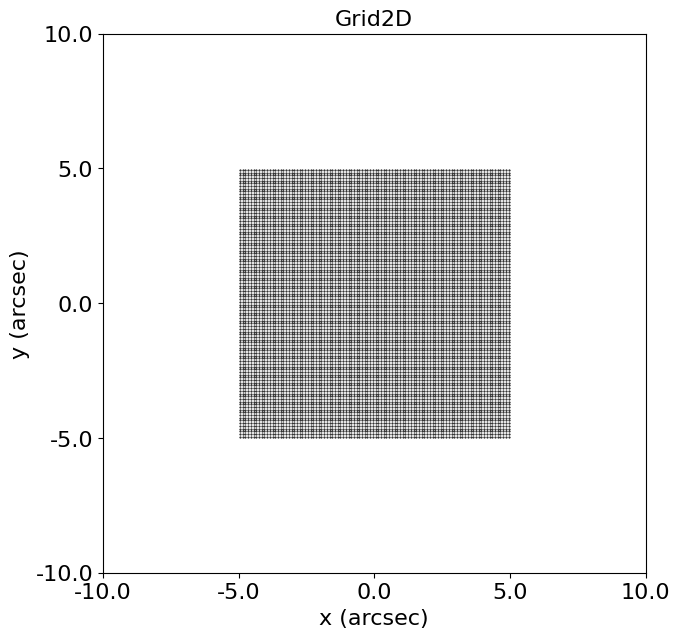

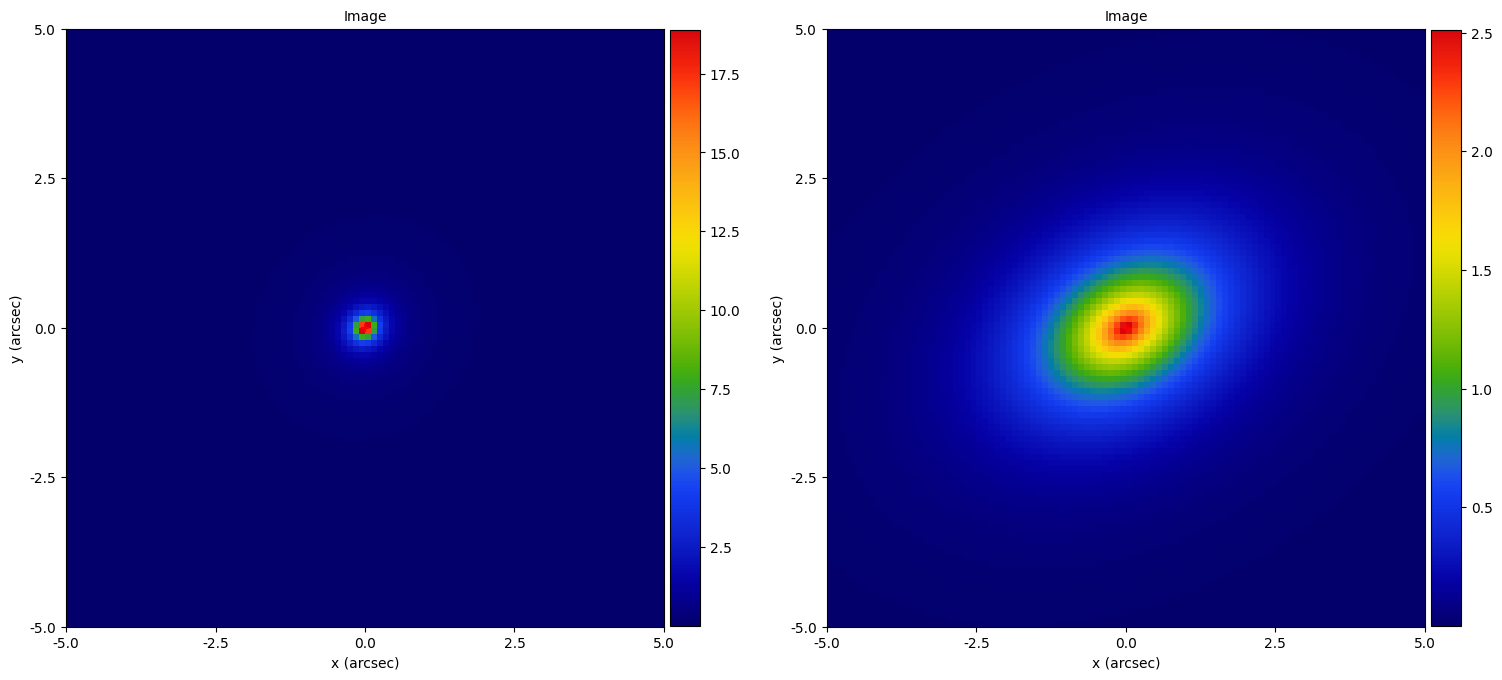

In [11]:
grid_2d = ag.Grid2D.uniform(
    shape_native=(100, 100),pixel_scales=0.1,)

grid_2d_plotter = aplt.Grid2DPlotter(grid=grid_2d)
grid_2d_plotter.figure_2d()

galaxy_plotter = aplt.GalaxyPlotter(galaxy=galaxy, grid=grid_2d)
#galaxy_plotter.figures_2d(image=True)
galaxy_plotter.subplot_of_light_profiles(image=True)


### Plane对象：用来组合多个星系形成的一个理论上的图像面

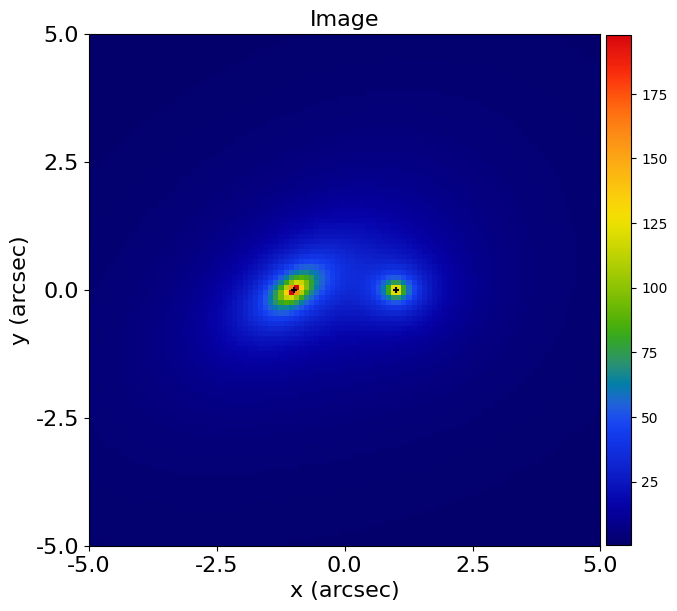

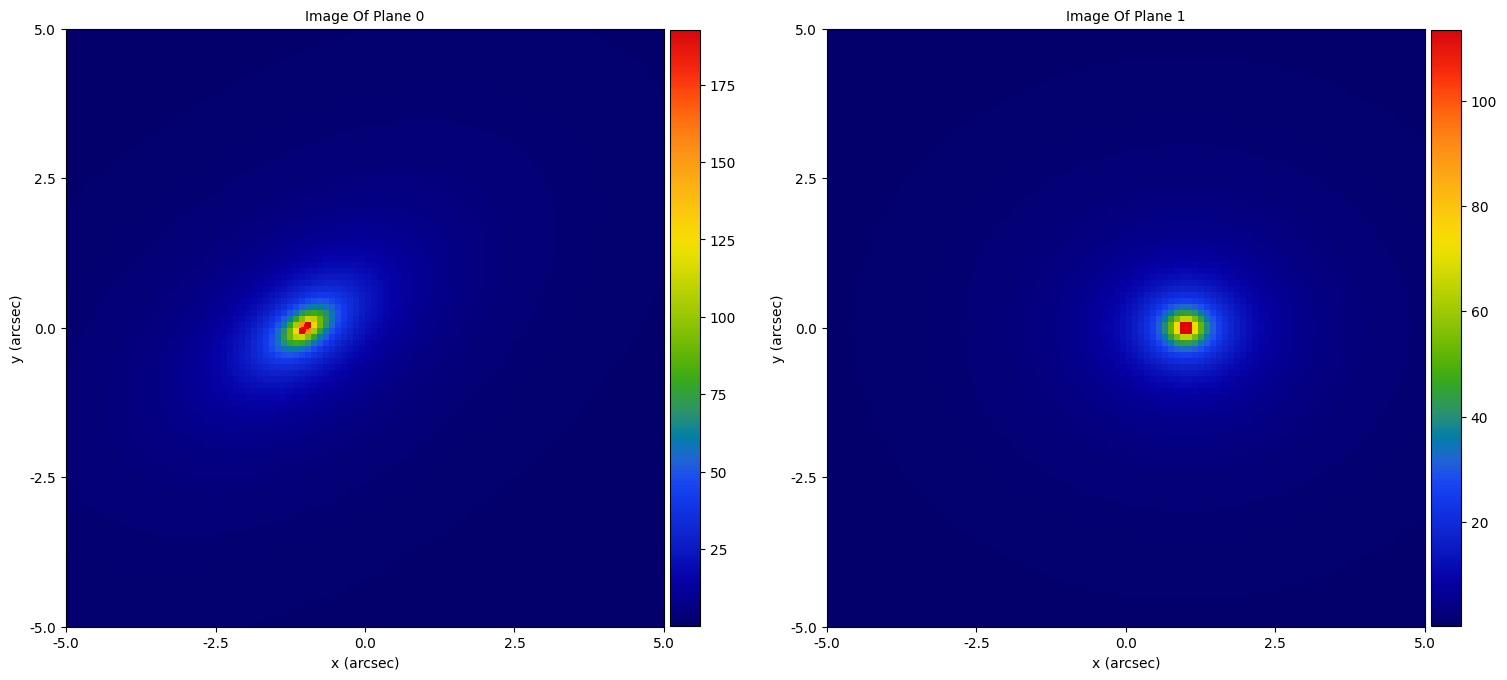

In [12]:
galaxy_0 = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.0, -1.0),
        ell_comps=(0.25, 0.1),
        intensity=5,
        effective_radius=2.5,
        sersic_index=2.5,
    ),
)

galaxy_1 = ag.Galaxy(
    redshift=0.3,
    bulge=ag.lp.Sersic(
        centre=(0.0, 1.0),
        ell_comps=(0.0, 0.1),
        intensity=2,
        effective_radius=3.0,
        sersic_index=3.0,
    ),
)

plane = ag.Plane(galaxies=[galaxy_0, galaxy_1])

image_2d = plane.image_2d_from(grid=grid_2d)
plane_plotter = aplt.PlanePlotter(plane=plane, grid=grid_2d)
plane_plotter.figures_2d(image=True)
plane_plotter.subplot_galaxy_images()


### 星系图像的拟合：Fitimaging操作
    - 只是将一个模型对象（Plane）和一个数据对象（imaging）进行差值

2023-02-24 12:35:44,524 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:35:44,672 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


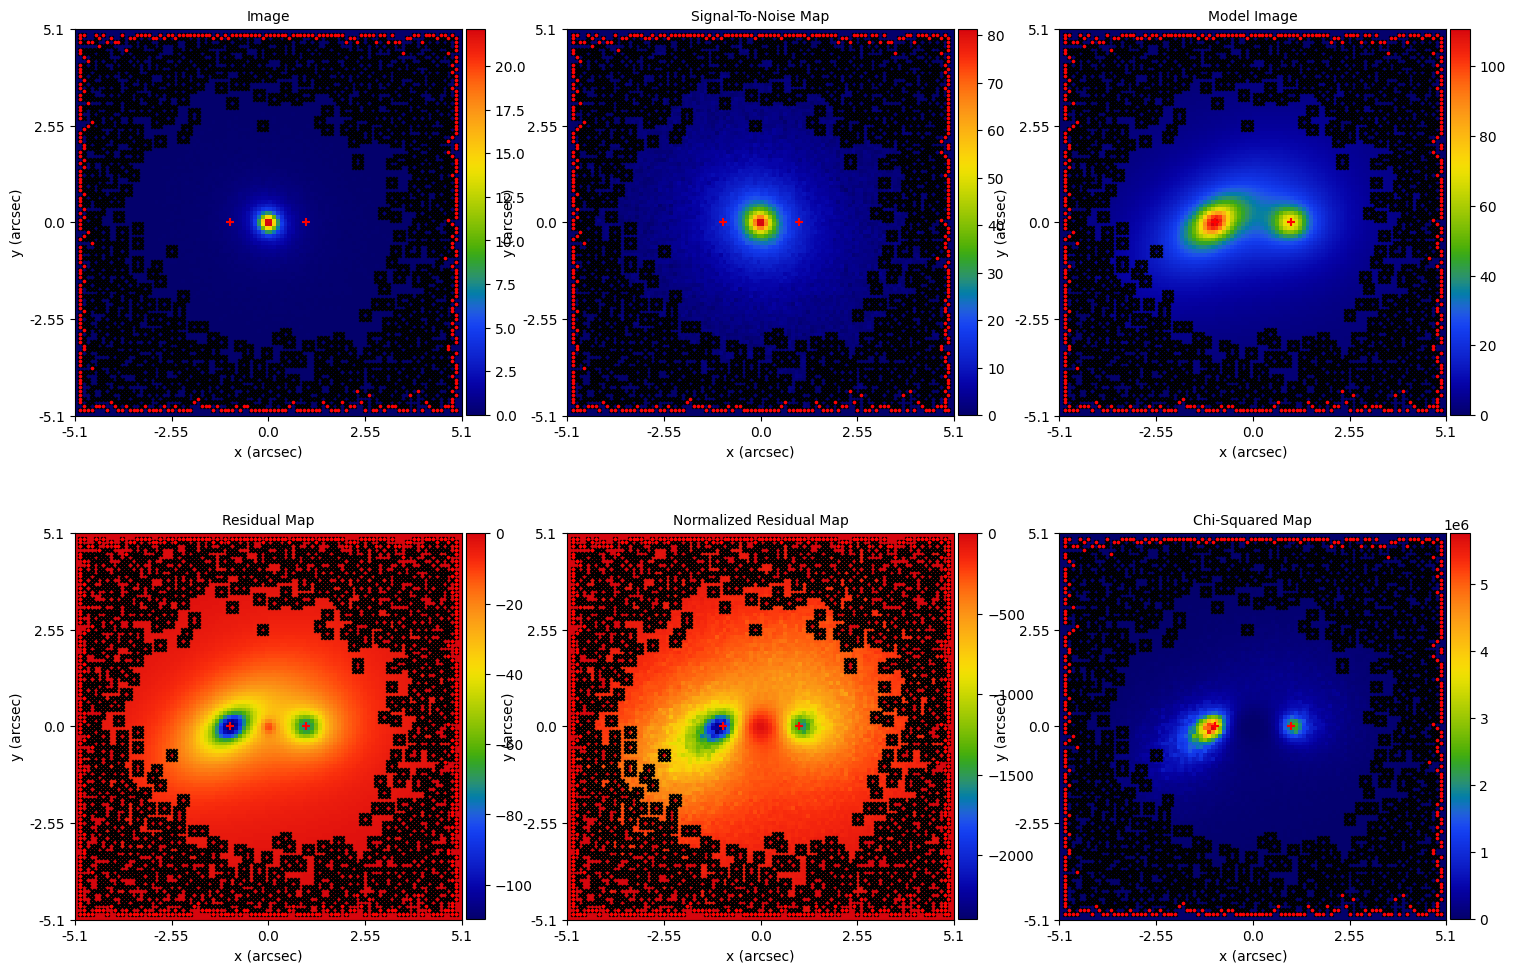

In [13]:
fit = ag.FitImaging(dataset=imaging, plane=plane)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
#fit_imaging_plotter.figures_2d(
#    residual_map=True,
#    normalized_residual_map=True,
#    chi_squared_map=True
#)
fit_imaging_plotter.subplot_fit_imaging()


### 对星系图像进行轮廓拟合
 - 调用Fit操作和autofit套件
 - autofit中的model对象（collection）：和autogalaxy中的plan对象类似，可以包含多个星系成份，背景成份等
 - autofit采用nestsampling算法

In [15]:
# 从fits文件读入图像
from os import path
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")


#dataset_name = "light_sersic"
#dataset_path = path.join("dataset", "imaging", dataset_name)

#imaging = ag.Imaging.from_fits(
#    image_path=path.join(dataset_path, "image.fits"),
#    noise_map_path=path.join(dataset_path, "noise_map.fits"),
#    psf_path=path.join(dataset_path, "psf.fits"),
##

imaging = ag.Imaging(image=ima_2d, noise_map=noise_2d, psf=psf_2d)


mask_2d = ag.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)
imaging = imaging.apply_mask(mask=mask_2d)


/home/shen
Working Directory has been set to `/home/shen`
2023-02-24 12:37:24,217 - autoarray.dataset.imaging.imaging - INFO - IMAGING - Data masked, contains a total of 2828 image-pixels


In [16]:
from pyprojroot import here
import autofit as af

galaxy = af.Model(ag.Galaxy, redshift=0.3, bulge=ag.lp.Sersic)
galaxies = af.Collection(galaxy=galaxy)
model = af.Collection(galaxies=galaxies)
print(model.info)
search = af.DynestyStatic(name="search_example3",nlive=40,walks=5)

analysis = ag.AnalysisImaging(dataset=imaging)
result = search.fit(model=model, analysis=analysis)


Total Free Parameters = 7

model                                                                           Collection (N=7)
    galaxies                                                                    Collection (N=7)
        galaxy                                                                  Galaxy (N=7)
            bulge                                                               Sersic (N=7)

galaxies
    galaxy
        redshift                                                                0.3
        bulge
            centre
                centre_0                                                        GaussianPrior [1], mean = 0.0, sigma = 0.3
                centre_1                                                        GaussianPrior [2], mean = 0.0, sigma = 0.3
            ell_comps
                ell_comps_0                                                     GaussianPrior [3], mean = 0.0, sigma = 0.3
                ell_comps_1                                     

98it [00:04, 23.64it/s, +40 | bound: 0 | nc: 1 | ncall: 581 | eff(%): 25.508 | loglstar:   -inf < -70481.993 <    inf | logz: -70488.820 +/-  5.510 | dlogz:  1.099 >  0.049]

2023-02-24 12:37:51,626 - search_example3 - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:37:53,807 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:37:53,893 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:37:56,539 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:37:56,627 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


127it [00:04, 30.91it/s, +40 | bound: 0 | nc: 1 | ncall: 1086 | eff(%): 15.966 | loglstar:   -inf < -29209.091 <    inf | logz: -29216.634 +/-  0.432 | dlogz:  1.099 >  0.049]

2023-02-24 12:38:02,564 - search_example3 - INFO - 1000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:38:04,481 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:04,565 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:07,222 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:07,309 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


150it [00:04, 30.19it/s, +40 | bound: 3 | nc: 1 | ncall: 1647 | eff(%): 11.823 | loglstar:   -inf < -29209.091 <    inf | logz: -29217.202 +/-  0.448 | dlogz:  1.099 >  0.049] 

2023-02-24 12:38:14,178 - search_example3 - INFO - 1500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:38:16,085 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:16,171 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:18,811 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:18,898 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


162it [00:05, 30.72it/s, +40 | bound: 9 | nc: 1 | ncall: 2168 | eff(%):  9.492 | loglstar:   -inf < -29209.091 <    inf | logz: -29217.498 +/-  0.456 | dlogz:  1.099 >  0.049] 

2023-02-24 12:38:26,146 - search_example3 - INFO - 2000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:38:28,070 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:28,157 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:30,774 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:30,858 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


176it [00:04, 35.78it/s, +40 | bound: 16 | nc: 1 | ncall: 2676 | eff(%):  8.194 | loglstar:   -inf < -29209.091 <    inf | logz: -29217.844 +/-  0.465 | dlogz:  1.099 >  0.049]

2023-02-24 12:38:37,338 - search_example3 - INFO - 2500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:38:39,266 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:39,884 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:42,531 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:42,619 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


185it [00:06, 26.52it/s, +40 | bound: 26 | nc: 1 | ncall: 3382 | eff(%):  6.732 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.066 +/-  0.471 | dlogz:  1.099 >  0.049]

2023-02-24 12:38:51,165 - search_example3 - INFO - 3000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:38:53,090 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:53,175 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:55,783 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:38:55,867 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


190it [00:07, 25.62it/s, +40 | bound: 36 | nc: 1 | ncall: 4107 | eff(%):  5.655 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.190 +/-  0.475 | dlogz:  1.099 >  0.049]

2023-02-24 12:39:04,842 - search_example3 - INFO - 3500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:39:07,376 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:07,461 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:10,075 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:10,159 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


197it [00:05, 35.80it/s, +40 | bound: 44 | nc: 1 | ncall: 4661 | eff(%):  5.129 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.363 +/-  0.479 | dlogz:  1.099 >  0.049]

2023-02-24 12:39:17,227 - search_example3 - INFO - 4000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:39:19,175 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:19,261 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:21,942 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:22,026 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


200it [00:06, 32.98it/s, +40 | bound: 52 | nc: 1 | ncall: 5235 | eff(%):  4.620 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.437 +/-  0.481 | dlogz:  1.099 >  0.049]

2023-02-24 12:39:29,682 - search_example3 - INFO - 4500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:39:32,323 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:32,407 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:35,012 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:35,097 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


201it [00:08, 24.13it/s, +40 | bound: 64 | nc: 1 | ncall: 6015 | eff(%):  4.033 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.461 +/-  0.481 | dlogz:  1.099 >  0.049]

2023-02-24 12:39:44,999 - search_example3 - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:39:46,963 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:47,047 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:49,688 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:49,774 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


206it [00:05, 37.98it/s, +40 | bound: 72 | nc: 1 | ncall: 6517 | eff(%):  3.798 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.585 +/-  0.485 | dlogz:  1.099 >  0.049]

2023-02-24 12:39:56,768 - search_example3 - INFO - 5500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:39:58,741 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:39:58,827 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:01,467 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:01,551 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


210it [00:07, 27.76it/s, +40 | bound: 81 | nc: 1 | ncall: 7192 | eff(%):  3.496 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.684 +/-  0.487 | dlogz:  1.099 >  0.049]

2023-02-24 12:40:11,641 - search_example3 - INFO - 6000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:40:13,609 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:13,696 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:16,320 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:16,405 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


218it [00:08, 25.27it/s, +40 | bound: 94 | nc: 1 | ncall: 8049 | eff(%):  3.221 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.881 +/-  0.492 | dlogz:  1.099 >  0.049]

2023-02-24 12:40:26,628 - search_example3 - INFO - 6500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:40:28,649 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:28,735 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:31,368 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:31,451 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


219it [00:06, 32.14it/s, +40 | bound: 104 | nc: 1 | ncall: 8664 | eff(%):  3.003 | loglstar:   -inf < -29209.091 <    inf | logz: -29218.906 +/-  0.492 | dlogz:  1.099 >  0.049]

2023-02-24 12:40:39,853 - search_example3 - INFO - 7000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:40:41,858 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:41,943 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:44,599 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:44,684 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


224it [00:06, 36.65it/s, +40 | bound: 112 | nc: 1 | ncall: 9261 | eff(%):  2.863 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.029 +/-  0.496 | dlogz:  1.099 >  0.049]

2023-02-24 12:40:52,393 - search_example3 - INFO - 7500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:40:55,567 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:55,655 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:58,321 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:40:58,407 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


227it [00:10, 21.52it/s, +40 | bound: 128 | nc: 1 | ncall: 10266 | eff(%):  2.611 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.103 +/-  0.497 | dlogz:  1.099 >  0.049]

2023-02-24 12:41:10,562 - search_example3 - INFO - 8000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:41:12,582 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:12,675 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:15,325 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:15,412 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


230it [00:15, 14.53it/s, +40 | bound: 153 | nc: 1 | ncall: 11824 | eff(%):  2.291 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.177 +/-  0.499 | dlogz:  1.099 >  0.049]

2023-02-24 12:41:32,870 - search_example3 - INFO - 8500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:41:34,935 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:35,019 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:37,677 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:37,765 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


232it [00:13, 16.60it/s, +40 | bound: 176 | nc: 1 | ncall: 13266 | eff(%):  2.057 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.227 +/-  0.500 | dlogz:  1.099 >  0.049]

2023-02-24 12:41:53,381 - search_example3 - INFO - 9000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:41:55,473 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:55,559 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:58,209 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:41:58,296 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


235it [00:18, 12.96it/s, +40 | bound: 203 | nc: 1 | ncall: 14933 | eff(%):  1.847 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.301 +/-  0.502 | dlogz:  1.099 >  0.049]

2023-02-24 12:42:18,082 - search_example3 - INFO - 9500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:42:21,696 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:21,788 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:24,432 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:24,517 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


239it [00:09, 24.37it/s, +40 | bound: 216 | nc: 1 | ncall: 15809 | eff(%):  1.769 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.400 +/-  0.505 | dlogz:  1.099 >  0.049]

2023-02-24 12:42:35,966 - search_example3 - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:42:38,091 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:38,179 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:40,805 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:40,891 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


242it [00:05, 41.09it/s, +40 | bound: 226 | nc: 1 | ncall: 16468 | eff(%):  1.717 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.474 +/-  0.506 | dlogz:  1.099 >  0.049]

2023-02-24 12:42:48,421 - search_example3 - INFO - 10500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:42:50,554 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:50,642 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:53,277 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:42:53,366 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


243it [00:08, 28.88it/s, +40 | bound: 239 | nc: 1 | ncall: 17276 | eff(%):  1.642 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.498 +/-  0.507 | dlogz:  1.099 >  0.049]

2023-02-24 12:43:03,435 - search_example3 - INFO - 11000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:43:05,554 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:05,638 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:08,252 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:08,336 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


245it [00:05, 44.15it/s, +40 | bound: 247 | nc: 1 | ncall: 17790 | eff(%):  1.606 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.548 +/-  0.508 | dlogz:  1.099 >  0.049]

2023-02-24 12:43:15,544 - search_example3 - INFO - 11500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:43:17,687 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:17,774 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:20,390 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:20,473 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


247it [00:08, 30.22it/s, +40 | bound: 259 | nc: 1 | ncall: 18545 | eff(%):  1.551 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.597 +/-  0.509 | dlogz:  1.099 >  0.049]

2023-02-24 12:43:32,076 - search_example3 - INFO - 12000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:43:34,233 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:34,320 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:36,984 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:37,072 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


248it [00:05, 48.65it/s, +40 | bound: 270 | nc: 1 | ncall: 19212 | eff(%):  1.502 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.622 +/-  0.510 | dlogz:  1.099 >  0.049]

2023-02-24 12:43:43,832 - search_example3 - INFO - 12500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:43:45,988 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:46,074 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:48,702 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:43:48,788 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


251it [00:07, 32.51it/s, +40 | bound: 281 | nc: 1 | ncall: 19945 | eff(%):  1.462 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.696 +/-  0.512 | dlogz:  1.099 >  0.049]

2023-02-24 12:43:58,163 - search_example3 - INFO - 13000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:44:00,312 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:00,396 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:03,013 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:03,097 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


254it [00:07, 35.00it/s, +40 | bound: 288 | nc: 1 | ncall: 20459 | eff(%):  1.440 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.770 +/-  0.514 | dlogz:  1.099 >  0.049]

2023-02-24 12:44:11,995 - search_example3 - INFO - 13500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:44:14,187 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:14,272 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:16,927 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:17,026 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


256it [00:11, 23.22it/s, +40 | bound: 301 | nc: 1 | ncall: 21315 | eff(%):  1.391 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.819 +/-  0.515 | dlogz:  1.099 >  0.049]

2023-02-24 12:44:29,727 - search_example3 - INFO - 14000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:44:31,919 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:32,002 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:34,609 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:34,692 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


261it [00:07, 36.70it/s, +40 | bound: 311 | nc: 1 | ncall: 22040 | eff(%):  1.368 | loglstar:   -inf < -29209.091 <    inf | logz: -29219.943 +/-  0.518 | dlogz:  1.099 >  0.049]

2023-02-24 12:44:43,473 - search_example3 - INFO - 14500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:44:45,655 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:45,741 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:50,547 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:44:50,636 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


265it [00:07, 33.68it/s, +40 | bound: 323 | nc: 1 | ncall: 22811 | eff(%):  1.339 | loglstar:   -inf < -29209.091 <    inf | logz: -29220.042 +/-  0.520 | dlogz:  1.099 >  0.049]

2023-02-24 12:45:00,192 - search_example3 - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:45:02,405 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:02,489 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:05,122 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:05,209 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


270it [00:06, 41.12it/s, +40 | bound: 333 | nc: 1 | ncall: 23511 | eff(%):  1.321 | loglstar:   -inf < -29209.091 <    inf | logz: -29220.165 +/-  0.523 | dlogz:  1.099 >  0.049]

2023-02-24 12:45:13,441 - search_example3 - INFO - 15500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:45:15,686 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:15,776 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:18,424 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:18,511 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


272it [00:10, 24.90it/s, +40 | bound: 347 | nc: 1 | ncall: 24399 | eff(%):  1.281 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.093 +/-  0.524 | dlogz:  1.099 >  0.049]

2023-02-24 12:45:31,113 - search_example3 - INFO - 16000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:45:33,364 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:33,451 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:36,092 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:36,178 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


274it [00:06, 45.16it/s, +40 | bound: 357 | nc: 1 | ncall: 25012 | eff(%):  1.257 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.142 +/-  0.525 | dlogz:  1.099 >  0.049]

2023-02-24 12:45:43,932 - search_example3 - INFO - 16500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:45:46,193 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:46,279 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:48,912 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:48,995 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


278it [00:04, 64.47it/s, +40 | bound: 366 | nc: 1 | ncall: 25571 | eff(%):  1.246 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.241 +/-  0.528 | dlogz:  1.099 >  0.049]

2023-02-24 12:45:54,979 - search_example3 - INFO - 17000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:45:57,222 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:57,309 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:45:59,957 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:00,042 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


281it [00:17, 16.29it/s, +40 | bound: 393 | nc: 1 | ncall: 27286 | eff(%):  1.178 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.315 +/-  0.529 | dlogz:  1.099 >  0.049]

2023-02-24 12:46:18,972 - search_example3 - INFO - 17500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:46:21,280 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:21,365 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:23,976 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:24,063 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


282it [00:12, 23.46it/s, +40 | bound: 413 | nc: 1 | ncall: 28541 | eff(%):  1.130 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.340 +/-  0.530 | dlogz:  1.099 >  0.049]

2023-02-24 12:46:37,769 - search_example3 - INFO - 18000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:46:40,046 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:40,130 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:45,434 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:45,518 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


284it [00:09, 31.47it/s, +40 | bound: 427 | nc: 1 | ncall: 29408 | eff(%):  1.103 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.389 +/-  0.531 | dlogz:  1.099 >  0.049]

2023-02-24 12:46:56,223 - search_example3 - INFO - 18500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:46:58,516 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:46:58,599 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:01,203 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:01,288 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


288it [00:06, 42.67it/s, +40 | bound: 437 | nc: 1 | ncall: 30082 | eff(%):  1.092 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.488 +/-  0.533 | dlogz:  1.099 >  0.049]

2023-02-24 12:47:09,741 - search_example3 - INFO - 19000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:47:12,074 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:12,162 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:14,794 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:14,880 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


290it [00:11, 25.50it/s, +40 | bound: 456 | nc: 1 | ncall: 31202 | eff(%):  1.059 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.537 +/-  0.534 | dlogz:  1.099 >  0.049]  

2023-02-24 12:47:27,953 - search_example3 - INFO - 19500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:47:30,270 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:30,354 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:32,970 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:33,053 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


292it [00:05, 54.82it/s, +40 | bound: 463 | nc: 1 | ncall: 31729 | eff(%):  1.048 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.587 +/-  0.536 | dlogz:  1.099 >  0.049]

2023-02-24 12:47:40,093 - search_example3 - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:47:42,435 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:42,519 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:45,136 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:47:45,221 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


294it [00:11, 25.03it/s, +40 | bound: 480 | nc: 1 | ncall: 32860 | eff(%):  1.018 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.636 +/-  0.537 | dlogz:  1.099 >  0.049]

2023-02-24 12:47:58,665 - search_example3 - INFO - 20500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:48:01,043 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:01,129 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:03,778 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:03,865 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


298it [00:05, 59.39it/s, +40 | bound: 487 | nc: 1 | ncall: 33389 | eff(%):  1.014 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.735 +/-  0.539 | dlogz:  1.099 >  0.049]

2023-02-24 12:48:10,598 - search_example3 - INFO - 21000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:48:12,966 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:13,048 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:15,658 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:15,743 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


299it [00:07, 42.14it/s, +40 | bound: 498 | nc: 1 | ncall: 34053 | eff(%):  0.997 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.760 +/-  0.540 | dlogz:  1.099 >  0.049]

2023-02-24 12:48:24,529 - search_example3 - INFO - 21500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:48:26,893 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:26,979 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:29,599 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:29,685 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


300it [00:10, 29.69it/s, +40 | bound: 513 | nc: 1 | ncall: 35007 | eff(%):  0.972 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.784 +/-  0.540 | dlogz:  1.099 >  0.049]

2023-02-24 12:48:41,499 - search_example3 - INFO - 22000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:48:43,914 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:43,998 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:46,655 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:48:46,741 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


302it [00:05, 51.21it/s, +40 | bound: 523 | nc: 1 | ncall: 35567 | eff(%):  0.963 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.834 +/-  0.541 | dlogz:  1.099 >  0.049]

2023-02-24 12:48:57,678 - search_example3 - INFO - 22500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:49:00,110 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:00,195 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:02,856 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:02,942 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


303it [00:05, 52.00it/s, +40 | bound: 532 | nc: 1 | ncall: 36134 | eff(%):  0.950 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.858 +/-  0.542 | dlogz:  1.099 >  0.049]

2023-02-24 12:49:10,500 - search_example3 - INFO - 23000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:49:12,969 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:13,054 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:15,687 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:15,772 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


308it [00:06, 48.99it/s, +40 | bound: 541 | nc: 1 | ncall: 36740 | eff(%):  0.948 | loglstar:   -inf < -19328.970 <    inf | logz: -19340.982 +/-  0.545 | dlogz:  1.099 >  0.049]

2023-02-24 12:49:23,815 - search_example3 - INFO - 23500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:49:26,247 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:26,335 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:28,978 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:29,061 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


312it [00:08, 37.25it/s, +40 | bound: 555 | nc: 1 | ncall: 37629 | eff(%):  0.936 | loglstar:   -inf < -19328.970 <    inf | logz: -19341.081 +/-  0.547 | dlogz:  1.099 >  0.049]

2023-02-24 12:49:39,173 - search_example3 - INFO - 24000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:49:41,634 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:41,718 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:44,352 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:44,440 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


316it [00:04, 64.73it/s, +40 | bound: 562 | nc: 1 | ncall: 38146 | eff(%):  0.934 | loglstar:   -inf < -19328.970 <    inf | logz: -19341.179 +/-  0.549 | dlogz:  1.099 >  0.049]

2023-02-24 12:49:51,086 - search_example3 - INFO - 24500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:49:53,523 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:53,608 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:56,249 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:49:56,336 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


323it [00:11, 27.31it/s, +40 | bound: 581 | nc: 1 | ncall: 39389 | eff(%):  0.923 | loglstar:   -inf < -19328.970 <    inf | logz: -19341.352 +/-  0.553 | dlogz:  1.099 >  0.049]

2023-02-24 12:50:09,931 - search_example3 - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:50:12,369 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:12,453 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:15,063 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:15,148 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


327it [00:05, 57.39it/s, +40 | bound: 591 | nc: 1 | ncall: 39981 | eff(%):  0.919 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.123 +/-  0.557 | dlogz:  1.099 >  0.049]

2023-02-24 12:50:22,609 - search_example3 - INFO - 25500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:50:25,077 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:25,162 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:27,824 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:27,906 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


331it [00:06, 53.88it/s, +40 | bound: 600 | nc: 1 | ncall: 40565 | eff(%):  0.915 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.221 +/-  0.559 | dlogz:  1.099 >  0.049]

2023-02-24 12:50:35,790 - search_example3 - INFO - 26000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:50:38,279 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:38,365 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:41,022 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:41,109 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


333it [00:05, 57.92it/s, +40 | bound: 610 | nc: 1 | ncall: 41170 | eff(%):  0.907 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.271 +/-  0.561 | dlogz:  1.099 >  0.049]

2023-02-24 12:50:48,636 - search_example3 - INFO - 26500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:50:51,135 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:51,223 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:53,850 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:50:53,935 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


337it [00:05, 60.86it/s, +40 | bound: 618 | nc: 1 | ncall: 41742 | eff(%):  0.904 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.370 +/-  0.563 | dlogz:  1.099 >  0.049]

2023-02-24 12:51:01,223 - search_example3 - INFO - 27000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:51:03,695 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:03,779 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:10,667 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:10,754 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


338it [00:05, 57.90it/s, +40 | bound: 627 | nc: 1 | ncall: 42300 | eff(%):  0.894 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.394 +/-  0.563 | dlogz:  1.099 >  0.049]

2023-02-24 12:51:18,381 - search_example3 - INFO - 27500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:51:20,897 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:20,982 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:23,607 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:23,692 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


340it [00:07, 47.50it/s, +40 | bound: 638 | nc: 1 | ncall: 43024 | eff(%):  0.884 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.444 +/-  0.564 | dlogz:  1.099 >  0.049]

2023-02-24 12:51:32,633 - search_example3 - INFO - 28000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:51:35,116 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:35,201 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:37,831 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:37,912 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


345it [00:05, 66.14it/s, +40 | bound: 646 | nc: 1 | ncall: 43592 | eff(%):  0.884 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.567 +/-  0.566 | dlogz:  1.099 >  0.049]

2023-02-24 12:51:44,902 - search_example3 - INFO - 28500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:51:47,407 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:47,494 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:50,164 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:51:50,246 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


351it [00:06, 54.91it/s, +40 | bound: 657 | nc: 1 | ncall: 44402 | eff(%):  0.881 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.715 +/-  0.569 | dlogz:  1.099 >  0.049]

2023-02-24 12:51:58,432 - search_example3 - INFO - 29000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:52:00,985 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:01,070 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:03,715 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:03,800 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


352it [00:10, 34.34it/s, +40 | bound: 674 | nc: 1 | ncall: 45433 | eff(%):  0.864 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.740 +/-  0.569 | dlogz:  1.099 >  0.049]


2023-02-24 12:52:15,840 - search_example3 - INFO - 29500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:52:18,397 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:18,483 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:21,116 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:21,201 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

353it [00:10, 32.51it/s, +40 | bound: 693 | nc: 1 | ncall: 46611 | eff(%):  0.844 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.765 +/-  0.570 | dlogz:  1.099 >  0.049]


2023-02-24 12:52:33,894 - search_example3 - INFO - 30000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:52:36,444 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:36,528 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:39,183 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:52:39,266 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

355it [00:22, 16.11it/s, +40 | bound: 730 | nc: 1 | ncall: 48857 | eff(%):  0.809 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.814 +/-  0.571 | dlogz:  1.099 >  0.049]


2023-02-24 12:53:03,096 - search_example3 - INFO - 30500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:53:05,678 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:05,768 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:08,402 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:08,485 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

356it [00:05, 68.86it/s, +40 | bound: 738 | nc: 1 | ncall: 49384 | eff(%):  0.803 | loglstar:   -inf < -17561.641 <    inf | logz: -17574.839 +/-  0.571 | dlogz:  1.099 >  0.049]


2023-02-24 12:53:15,476 - search_example3 - INFO - 31000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:53:18,093 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:18,179 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:20,830 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:20,915 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

358it [00:04, 75.00it/s, +40 | bound: 746 | nc: 1 | ncall: 49909 | eff(%):  0.798 | loglstar:   -inf < -15876.860 <    inf | logz: -15890.107 +/-  0.572 | dlogz:  1.099 >  0.049]

2023-02-24 12:53:27,503 - search_example3 - INFO - 31500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:53:30,141 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:30,226 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:32,887 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:32,973 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


359it [00:12, 28.78it/s, +40 | bound: 767 | nc: 1 | ncall: 51175 | eff(%):  0.780 | loglstar:   -inf < -15876.860 <    inf | logz: -15890.131 +/-  0.572 | dlogz:  1.099 >  0.049]


2023-02-24 12:53:47,263 - search_example3 - INFO - 32000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:53:49,870 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:49,956 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:52,581 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:53:52,667 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

361it [00:05, 69.83it/s, +40 | bound: 775 | nc: 1 | ncall: 51696 | eff(%):  0.776 | loglstar:   -inf < -15876.860 <    inf | logz: -15890.181 +/-  0.574 | dlogz:  1.099 >  0.049]

2023-02-24 12:53:59,675 - search_example3 - INFO - 32500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:54:02,314 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:02,400 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:10,274 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:10,365 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


363it [00:09, 36.65it/s, +40 | bound: 786 | nc: 1 | ncall: 52424 | eff(%):  0.769 | loglstar:   -inf < -15876.860 <    inf | logz: -15890.230 +/-  0.575 | dlogz:  1.099 >  0.049]

2023-02-24 12:54:22,147 - search_example3 - INFO - 33000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:54:24,860 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:24,952 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:27,717 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:27,804 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


365it [00:12, 28.89it/s, +40 | bound: 806 | nc: 1 | ncall: 53709 | eff(%):  0.755 | loglstar:   -inf < -15876.860 <    inf | logz: -15890.280 +/-  0.576 | dlogz:  1.099 >  0.049]

2023-02-24 12:54:42,313 - search_example3 - INFO - 33500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:54:45,047 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:45,132 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:47,797 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:54:47,883 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


367it [00:20, 17.66it/s, +40 | bound: 836 | nc: 1 | ncall: 55601 | eff(%):  0.733 | loglstar:   -inf < -15685.857 <    inf | logz: -15699.326 +/-  0.577 | dlogz:  1.099 >  0.049] 


2023-02-24 12:55:10,522 - search_example3 - INFO - 34000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:55:13,207 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:13,289 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:15,929 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:16,014 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

371it [00:07, 52.47it/s, +40 | bound: 848 | nc: 1 | ncall: 56308 | eff(%):  0.730 | loglstar:   -inf < -15685.857 <    inf | logz: -15699.425 +/-  0.579 | dlogz:  1.099 >  0.049]

2023-02-24 12:55:24,930 - search_example3 - INFO - 34500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:55:27,650 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:27,735 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:30,360 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:30,444 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


375it [00:05, 67.70it/s, +40 | bound: 856 | nc: 1 | ncall: 56889 | eff(%):  0.730 | loglstar:   -inf < -15685.857 <    inf | logz: -15699.524 +/-  0.581 | dlogz:  1.099 >  0.049]

2023-02-24 12:55:37,841 - search_example3 - INFO - 35000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:55:40,556 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:40,642 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:43,300 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:43,385 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


380it [00:05, 69.13it/s, +40 | bound: 864 | nc: 1 | ncall: 57449 | eff(%):  0.732 | loglstar:   -inf < -15685.857 <    inf | logz: -15699.647 +/-  0.584 | dlogz:  1.099 >  0.049]

2023-02-24 12:55:50,730 - search_example3 - INFO - 35500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:55:53,441 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:53,524 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:56,174 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:55:56,256 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


390it [00:08, 44.61it/s, +40 | bound: 879 | nc: 1 | ncall: 58476 | eff(%):  0.736 | loglstar:   -inf < -12326.398 <    inf | logz: -12340.435 +/-  0.589 | dlogz:  1.099 >  0.049]

2023-02-24 12:56:06,850 - search_example3 - INFO - 36000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:56:09,548 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:09,631 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:12,220 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:12,304 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


393it [00:09, 40.05it/s, +40 | bound: 895 | nc: 1 | ncall: 59475 | eff(%):  0.729 | loglstar:   -inf < -12326.398 <    inf | logz: -12340.509 +/-  0.590 | dlogz:  1.099 >  0.049]

2023-02-24 12:56:23,947 - search_example3 - INFO - 36500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:56:26,670 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:26,754 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:29,360 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:29,445 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


401it [00:06, 58.24it/s, +40 | bound: 905 | nc: 1 | ncall: 60188 | eff(%):  0.733 | loglstar:   -inf < -12326.398 <    inf | logz: -12340.707 +/-  0.594 | dlogz:  1.099 >  0.049]

2023-02-24 12:56:38,183 - search_example3 - INFO - 37000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:56:40,960 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:41,047 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:43,679 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:43,765 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


416it [00:04, 86.13it/s, +40 | bound: 911 | nc: 1 | ncall: 60709 | eff(%):  0.752 | loglstar:   -inf < -2690.760 <    inf | logz: -2705.439 +/-  0.602 | dlogz:  1.099 >  0.049]  

2023-02-24 12:56:50,462 - search_example3 - INFO - 37500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:56:53,215 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:53,301 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:55,933 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:56:56,018 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


426it [00:05, 83.47it/s, +40 | bound: 919 | nc: 1 | ncall: 61273 | eff(%):  0.761 | loglstar:   -inf < -2690.760 <    inf | logz: -2705.686 +/-  0.607 | dlogz:  1.099 >  0.049]  

2023-02-24 12:57:02,986 - search_example3 - INFO - 38000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:57:05,768 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:05,854 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:08,497 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:08,582 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


432it [00:06, 65.16it/s, +40 | bound: 929 | nc: 1 | ncall: 61957 | eff(%):  0.762 | loglstar:   -inf < -2690.760 <    inf | logz: -2705.834 +/-  0.610 | dlogz:  1.099 >  0.049]  

2023-02-24 12:57:17,080 - search_example3 - INFO - 38500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:57:19,858 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:19,945 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:22,590 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:22,675 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


436it [00:05, 81.07it/s, +40 | bound: 938 | nc: 1 | ncall: 62545 | eff(%):  0.762 | loglstar:   -inf < -2690.760 <    inf | logz: -2705.933 +/-  0.612 | dlogz:  1.099 >  0.049]  

2023-02-24 12:57:29,945 - search_example3 - INFO - 39000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:57:32,748 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:32,835 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:41,824 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:41,912 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


440it [00:05, 82.29it/s, +40 | bound: 947 | nc: 1 | ncall: 63099 | eff(%):  0.761 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.031 +/-  0.614 | dlogz:  1.099 >  0.049]  


2023-02-24 12:57:49,229 - search_example3 - INFO - 39500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:57:52,092 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:52,178 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:54,859 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:57:54,945 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

441it [00:07, 60.75it/s, +40 | bound: 958 | nc: 1 | ncall: 63764 | eff(%):  0.755 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.056 +/-  0.615 | dlogz:  1.099 >  0.049] 


2023-02-24 12:58:04,127 - search_example3 - INFO - 40000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:58:06,981 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:07,070 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:09,759 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:09,846 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

449it [00:05, 79.22it/s, +40 | bound: 966 | nc: 1 | ncall: 64360 | eff(%):  0.760 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.254 +/-  0.619 | dlogz:  1.099 >  0.049]  

2023-02-24 12:58:17,418 - search_example3 - INFO - 40500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:58:20,277 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:20,363 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:23,019 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:23,104 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


453it [00:10, 44.13it/s, +40 | bound: 983 | nc: 1 | ncall: 65443 | eff(%):  0.754 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.352 +/-  0.620 | dlogz:  1.099 >  0.049]  

2023-02-24 12:58:35,276 - search_example3 - INFO - 41000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:58:38,090 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:38,176 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:40,797 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:40,884 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


460it [00:10, 45.92it/s, +40 | bound: 1000 | nc: 1 | ncall: 66537 | eff(%):  0.752 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.525 +/-  0.624 | dlogz:  1.099 >  0.049]

2023-02-24 12:58:52,781 - search_example3 - INFO - 41500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:58:55,605 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:55,688 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:58,299 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:58:58,382 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


471it [00:05, 86.15it/s, +40 | bound: 1009 | nc: 1 | ncall: 67142 | eff(%):  0.762 | loglstar:   -inf < -2690.760 <    inf | logz: -2706.797 +/-  0.630 | dlogz:  1.099 >  0.049] 

2023-02-24 12:59:05,730 - search_example3 - INFO - 42000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:59:08,574 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:08,666 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:11,299 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:11,382 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


480it [00:06, 79.25it/s, +40 | bound: 1017 | nc: 1 | ncall: 67792 | eff(%):  0.768 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.019 +/-  0.634 | dlogz:  1.099 >  0.049]  

2023-02-24 12:59:19,324 - search_example3 - INFO - 42500 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 12:59:22,196 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:22,281 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:24,897 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:24,981 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


486it [00:05, 90.40it/s, +40 | bound: 1025 | nc: 1 | ncall: 68318 | eff(%):  0.770 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.167 +/-  0.637 | dlogz:  1.099 >  0.049]  


2023-02-24 12:59:32,261 - search_example3 - INFO - 43000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:59:35,128 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:35,212 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:37,821 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:37,905 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

487it [00:05, 85.32it/s, +40 | bound: 1036 | nc: 1 | ncall: 68944 | eff(%):  0.765 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.192 +/-  0.637 | dlogz:  1.099 >  0.049] 


2023-02-24 12:59:45,556 - search_example3 - INFO - 43500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 12:59:48,433 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:48,519 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:51,144 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 12:59:51,228 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

494it [00:08, 58.85it/s, +40 | bound: 1049 | nc: 1 | ncall: 69862 | eff(%):  0.765 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.365 +/-  0.641 | dlogz:  1.099 >  0.049]  


2023-02-24 13:00:01,526 - search_example3 - INFO - 44000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:00:04,434 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:04,518 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:07,162 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:07,247 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

496it [00:11, 44.05it/s, +40 | bound: 1068 | nc: 1 | ncall: 71046 | eff(%):  0.755 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.414 +/-  0.641 | dlogz:  1.099 >  0.049]  


2023-02-24 13:00:20,439 - search_example3 - INFO - 44500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:00:23,352 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:23,436 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:26,044 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:26,130 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

498it [00:12, 40.30it/s, +40 | bound: 1090 | nc: 1 | ncall: 72408 | eff(%):  0.743 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.463 +/-  0.642 | dlogz:  1.099 >  0.049]  

2023-02-24 13:00:40,384 - search_example3 - INFO - 45000 Iterations: Performing update (Visualization, outputting samples, etc.).


2023-02-24 13:00:43,294 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:43,380 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:46,014 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:00:46,099 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    


500it [00:12, 40.78it/s, +40 | bound: 1111 | nc: 1 | ncall: 73730 | eff(%):  0.733 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.513 +/-  0.643 | dlogz:  1.099 >  0.049]  


2023-02-24 13:01:00,281 - search_example3 - INFO - 45500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:01:03,223 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:03,308 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:05,938 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:06,023 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

513it [00:04, 103.57it/s, +40 | bound: 1117 | nc: 1 | ncall: 74242 | eff(%):  0.745 | loglstar:   -inf < -2690.760 <    inf | logz: -2707.834 +/-  0.649 | dlogz:  1.099 >  0.049]


2023-02-24 13:01:12,920 - search_example3 - INFO - 46000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:01:15,846 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:15,934 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:18,549 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:18,631 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

528it [00:04, 113.67it/s, +40 | bound: 1123 | nc: 1 | ncall: 74753 | eff(%):  0.760 | loglstar:   -inf < -2690.760 <    inf | logz: -2708.204 +/-  0.657 | dlogz:  1.099 >  0.049] 


2023-02-24 13:01:25,199 - search_example3 - INFO - 46500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:01:28,137 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:28,219 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:37,941 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:38,042 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

533it [00:05, 99.42it/s, +40 | bound: 1131 | nc: 1 | ncall: 75293 | eff(%):  0.761 | loglstar:   -inf < -2690.760 <    inf | logz: -2708.328 +/-  0.659 | dlogz:  1.099 >  0.049] 


2023-02-24 13:01:45,437 - search_example3 - INFO - 47000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:01:48,475 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:48,563 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:51,242 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:01:51,326 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

547it [00:04, 111.54it/s, +40 | bound: 1140 | nc: 1 | ncall: 75933 | eff(%):  0.773 | loglstar:   -inf < -2690.760 <    inf | logz: -2708.673 +/-  0.665 | dlogz:  1.099 >  0.049]


2023-02-24 13:01:58,259 - search_example3 - INFO - 47500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:02:01,247 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:01,331 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:03,968 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:04,053 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

555it [00:05, 108.10it/s, +40 | bound: 1147 | nc: 1 | ncall: 76459 | eff(%):  0.779 | loglstar:   -inf < -2690.760 <    inf | logz: -2708.871 +/-  0.669 | dlogz:  1.099 >  0.049]


2023-02-24 13:02:11,156 - search_example3 - INFO - 48000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:02:14,191 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:14,278 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:16,914 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:17,000 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

569it [00:05, 112.21it/s, +40 | bound: 1154 | nc: 1 | ncall: 76972 | eff(%):  0.792 | loglstar:   -inf < 658.640 <    inf | logz: 640.183 +/-  0.675 | dlogz:  1.099 >  0.049] 


2023-02-24 13:02:24,036 - search_example3 - INFO - 48500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:02:27,029 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:27,135 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:29,785 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:29,869 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

576it [00:06, 85.09it/s, +40 | bound: 1165 | nc: 1 | ncall: 77654 | eff(%):  0.794 | loglstar:   -inf < 658.640 <    inf | logz: 640.011 +/-  0.678 | dlogz:  1.099 >  0.049]   


2023-02-24 13:02:38,597 - search_example3 - INFO - 49000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:02:41,617 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:41,706 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:44,351 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:44,436 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

584it [00:04, 117.99it/s, +40 | bound: 1174 | nc: 1 | ncall: 78288 | eff(%):  0.797 | loglstar:   -inf < 658.640 <    inf | logz: 639.813 +/-  0.682 | dlogz:  1.099 >  0.049]  


2023-02-24 13:02:51,350 - search_example3 - INFO - 49500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:02:54,376 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:54,459 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:57,096 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:02:57,182 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

586it [00:06, 96.83it/s, +40 | bound: 1184 | nc: 1 | ncall: 78913 | eff(%):  0.794 | loglstar:   -inf < 658.640 <    inf | logz: 639.764 +/-  0.683 | dlogz:  1.099 >  0.049]  


2023-02-24 13:03:05,211 - search_example3 - INFO - 50000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:03:08,286 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:08,372 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:11,018 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:11,104 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

591it [00:06, 93.00it/s, +40 | bound: 1194 | nc: 1 | ncall: 79555 | eff(%):  0.794 | loglstar:   -inf < 658.640 <    inf | logz: 639.640 +/-  0.685 | dlogz:  1.099 >  0.049]   


2023-02-24 13:03:19,435 - search_example3 - INFO - 50500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:03:22,472 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:22,557 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:25,180 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:25,266 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

594it [00:05, 112.39it/s, +40 | bound: 1202 | nc: 1 | ncall: 80105 | eff(%):  0.792 | loglstar:   -inf < 658.640 <    inf | logz: 639.566 +/-  0.686 | dlogz:  1.099 >  0.049]  


2023-02-24 13:03:32,523 - search_example3 - INFO - 51000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:03:35,600 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:35,688 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:38,307 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:38,391 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

596it [00:06, 96.75it/s, +40 | bound: 1212 | nc: 1 | ncall: 80761 | eff(%):  0.788 | loglstar:   -inf < 658.640 <    inf | logz: 639.517 +/-  0.687 | dlogz:  1.099 >  0.049]   


2023-02-24 13:03:46,518 - search_example3 - INFO - 51500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:03:49,596 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:49,682 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:52,329 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:03:52,413 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

602it [00:09, 65.43it/s, +40 | bound: 1226 | nc: 1 | ncall: 81712 | eff(%):  0.786 | loglstar:   -inf < 658.640 <    inf | logz: 639.369 +/-  0.690 | dlogz:  1.099 >  0.049]   


2023-02-24 13:04:03,608 - search_example3 - INFO - 52000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:04:06,793 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:06,881 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:09,585 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:09,669 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

603it [00:08, 67.60it/s, +40 | bound: 1237 | nc: 1 | ncall: 82414 | eff(%):  0.781 | loglstar:   -inf < 658.640 <    inf | logz: 639.344 +/-  0.690 | dlogz:  1.099 >  0.049]  


2023-02-24 13:04:20,587 - search_example3 - INFO - 52500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:04:23,672 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:23,755 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:26,373 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:26,457 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

608it [00:06, 93.55it/s, +40 | bound: 1247 | nc: 1 | ncall: 83079 | eff(%):  0.780 | loglstar:   -inf < 658.640 <    inf | logz: 639.220 +/-  0.693 | dlogz:  1.099 >  0.049]  


2023-02-24 13:04:35,004 - search_example3 - INFO - 53000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:04:38,119 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:38,205 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:40,852 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:40,936 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

616it [00:05, 108.51it/s, +40 | bound: 1254 | nc: 1 | ncall: 83676 | eff(%):  0.784 | loglstar:   -inf < 658.640 <    inf | logz: 639.023 +/-  0.696 | dlogz:  1.099 >  0.049]  


2023-02-24 13:04:48,628 - search_example3 - INFO - 53500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:04:51,731 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:51,816 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:54,468 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:04:54,551 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

622it [00:05, 123.28it/s, +40 | bound: 1261 | nc: 1 | ncall: 84215 | eff(%):  0.786 | loglstar:   -inf < 658.640 <    inf | logz: 638.875 +/-  0.700 | dlogz:  1.099 >  0.049]  


2023-02-24 13:05:01,602 - search_example3 - INFO - 54000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:05:04,727 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:04,812 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:07,433 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:07,518 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

626it [00:05, 118.41it/s, +40 | bound: 1269 | nc: 1 | ncall: 84767 | eff(%):  0.786 | loglstar:   -inf < 658.640 <    inf | logz: 638.776 +/-  0.701 | dlogz:  1.099 >  0.049]  


2023-02-24 13:05:14,804 - search_example3 - INFO - 54500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:05:17,938 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:18,029 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:20,678 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:20,761 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

637it [00:04, 131.07it/s, +40 | bound: 1276 | nc: 1 | ncall: 85279 | eff(%):  0.794 | loglstar:   -inf < 658.640 <    inf | logz: 638.504 +/-  0.707 | dlogz:  1.099 >  0.049] 


2023-02-24 13:05:27,669 - search_example3 - INFO - 55000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:05:39,565 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:39,652 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:42,319 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:42,408 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

646it [00:05, 126.50it/s, +40 | bound: 1284 | nc: 1 | ncall: 85824 | eff(%):  0.800 | loglstar:   -inf < 658.640 <    inf | logz: 638.282 +/-  0.710 | dlogz:  1.099 >  0.049]  


2023-02-24 13:05:49,605 - search_example3 - INFO - 55500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:05:52,848 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:52,938 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:55,659 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:05:55,748 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

658it [00:05, 118.92it/s, +40 | bound: 1292 | nc: 1 | ncall: 86394 | eff(%):  0.808 | loglstar:   -inf < 658.640 <    inf | logz: 637.986 +/-  0.715 | dlogz:  1.099 >  0.049]  


2023-02-24 13:06:03,415 - search_example3 - INFO - 56000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:06:06,648 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:06,763 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:09,407 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:09,490 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

659it [00:07, 82.53it/s, +40 | bound: 1305 | nc: 1 | ncall: 87227 | eff(%):  0.802 | loglstar:   -inf < 658.640 <    inf | logz: 637.961 +/-  0.715 | dlogz:  1.099 >  0.049]  


2023-02-24 13:06:19,538 - search_example3 - INFO - 56500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:06:22,729 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:22,815 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:25,487 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:25,576 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

668it [00:05, 115.74it/s, +40 | bound: 1313 | nc: 1 | ncall: 87823 | eff(%):  0.807 | loglstar:   -inf < 658.640 <    inf | logz: 637.739 +/-  0.720 | dlogz:  1.099 >  0.049]  


2023-02-24 13:06:33,399 - search_example3 - INFO - 57000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:06:36,587 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:36,674 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:39,299 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:39,384 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

670it [00:08, 82.27it/s, +40 | bound: 1327 | nc: 1 | ncall: 88688 | eff(%):  0.801 | loglstar:   -inf < 658.640 <    inf | logz: 637.689 +/-  0.720 | dlogz:  1.099 >  0.049]  


2023-02-24 13:06:49,598 - search_example3 - INFO - 57500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:06:52,818 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:52,904 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:55,576 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:06:55,664 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

678it [00:19, 35.11it/s, +40 | bound: 1364 | nc: 1 | ncall: 90962 | eff(%):  0.790 | loglstar:   -inf < 658.640 <    inf | logz: 637.492 +/-  0.724 | dlogz:  1.099 >  0.049]   


2023-02-24 13:07:17,047 - search_example3 - INFO - 58000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:07:20,278 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:20,361 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:23,008 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:23,094 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

680it [00:05, 122.50it/s, +40 | bound: 1373 | nc: 1 | ncall: 91549 | eff(%):  0.787 | loglstar:   -inf < 658.640 <    inf | logz: 637.443 +/-  0.724 | dlogz:  1.099 >  0.049]  


2023-02-24 13:07:30,688 - search_example3 - INFO - 58500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:07:33,912 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:33,995 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:36,619 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:36,701 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

695it [00:06, 115.59it/s, +40 | bound: 1381 | nc: 1 | ncall: 92193 | eff(%):  0.798 | loglstar:   -inf < 658.640 <    inf | logz: 637.072 +/-  0.731 | dlogz:  1.099 >  0.049]  


2023-02-24 13:07:44,752 - search_example3 - INFO - 59000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:07:47,981 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:48,067 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:50,722 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:07:50,807 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

700it [00:07, 97.72it/s, +40 | bound: 1392 | nc: 1 | ncall: 92966 | eff(%):  0.796 | loglstar:   -inf < 658.640 <    inf | logz: 636.949 +/-  0.733 | dlogz:  1.099 >  0.049]   


2023-02-24 13:08:00,024 - search_example3 - INFO - 59500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:08:03,278 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:03,364 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:05,985 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:06,067 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

712it [00:06, 117.32it/s, +40 | bound: 1399 | nc: 1 | ncall: 93577 | eff(%):  0.804 | loglstar:   -inf < 658.640 <    inf | logz: 636.654 +/-  0.734 | dlogz:  1.098 >  0.049]  


2023-02-24 13:08:14,191 - search_example3 - INFO - 60000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:08:17,452 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:17,539 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:20,179 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:20,265 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

721it [00:05, 136.14it/s, +40 | bound: 1406 | nc: 1 | ncall: 94112 | eff(%):  0.809 | loglstar:   -inf < 1447.433 <    inf | logz: 1425.223 +/-  0.743 | dlogz:  1.099 >  0.049]


2023-02-24 13:08:27,616 - search_example3 - INFO - 60500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:08:30,872 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:30,960 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:33,616 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:33,702 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

734it [00:05, 140.45it/s, +40 | bound: 1413 | nc: 1 | ncall: 94625 | eff(%):  0.818 | loglstar:   -inf < 1535.706 <    inf | logz: 1513.175 +/-  0.750 | dlogz:  1.099 >  0.049]


2023-02-24 13:08:40,993 - search_example3 - INFO - 61000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:08:44,238 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:44,321 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:46,933 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:47,015 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

755it [00:05, 143.81it/s, +40 | bound: 1421 | nc: 1 | ncall: 95131 | eff(%):  0.836 | loglstar:   -inf < 1535.706 <    inf | logz: 1512.656 +/-  0.756 | dlogz:  1.099 >  0.049]


2023-02-24 13:08:54,328 - search_example3 - INFO - 61500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:08:57,596 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:08:57,681 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:00,305 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:00,394 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

767it [00:05, 149.80it/s, +40 | bound: 1428 | nc: 1 | ncall: 95667 | eff(%):  0.844 | loglstar:   -inf < 1683.712 <    inf | logz: 1660.366 +/-  0.761 | dlogz:  1.099 >  0.049]


2023-02-24 13:09:07,619 - search_example3 - INFO - 62000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:09:10,887 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:10,974 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:13,633 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:13,728 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

779it [00:05, 155.30it/s, +40 | bound: 1435 | nc: 1 | ncall: 96213 | eff(%):  0.852 | loglstar:   -inf < 1683.712 <    inf | logz: 1660.069 +/-  0.765 | dlogz:  1.099 >  0.049]


2023-02-24 13:09:20,846 - search_example3 - INFO - 62500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:09:24,143 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:24,230 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:26,851 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:26,935 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

801it [00:05, 148.72it/s, +40 | bound: 1442 | nc: 1 | ncall: 96754 | eff(%):  0.870 | loglstar:   -inf < 1683.712 <    inf | logz: 1659.526 +/-  0.777 | dlogz:  1.099 >  0.049]


2023-02-24 13:09:34,396 - search_example3 - INFO - 63000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:09:37,710 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:37,796 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:40,419 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:40,500 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

807it [00:03, 205.58it/s, +40 | bound: 1451 | nc: 1 | ncall: 97286 | eff(%):  0.871 | loglstar:   -inf < 1683.712 <    inf | logz: 1659.378 +/-  0.779 | dlogz:  1.099 >  0.049]


2023-02-24 13:09:46,492 - search_example3 - INFO - 63500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:09:49,778 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:49,863 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:52,478 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:09:52,562 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

822it [00:05, 161.43it/s, +40 | bound: 1458 | nc: 1 | ncall: 97851 | eff(%):  0.881 | loglstar:   -inf < 1758.408 <    inf | logz: 1733.704 +/-  0.794 | dlogz:  1.099 >  0.049]


2023-02-24 13:09:59,728 - search_example3 - INFO - 64000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:10:03,089 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:03,175 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:05,820 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:05,905 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

832it [00:05, 149.38it/s, +40 | bound: 1466 | nc: 1 | ncall: 98405 | eff(%):  0.886 | loglstar:   -inf < 1860.418 <    inf | logz: 1835.467 +/-  0.794 | dlogz:  1.099 >  0.049]


2023-02-24 13:10:13,570 - search_example3 - INFO - 64500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:10:27,027 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:27,112 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:29,756 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:29,843 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

847it [00:05, 163.12it/s, +40 | bound: 1473 | nc: 1 | ncall: 98944 | eff(%):  0.897 | loglstar:   -inf < 1860.418 <    inf | logz: 1835.097 +/-  0.798 | dlogz:  1.099 >  0.049]


2023-02-24 13:10:37,196 - search_example3 - INFO - 65000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:10:40,599 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:40,684 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:43,393 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:43,480 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

858it [00:05, 164.60it/s, +40 | bound: 1479 | nc: 1 | ncall: 99460 | eff(%):  0.903 | loglstar:   -inf < 2046.193 <    inf | logz: 2020.600 +/-  0.800 | dlogz:  1.099 >  0.049]


2023-02-24 13:10:50,888 - search_example3 - INFO - 65500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:10:54,318 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:54,404 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:57,070 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:10:57,158 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

872it [00:05, 160.54it/s, +40 | bound: 1486 | nc: 1 | ncall: 99962 | eff(%):  0.913 | loglstar:   -inf < 2046.193 <    inf | logz: 2020.254 +/-  0.809 | dlogz:  1.099 >  0.049]


2023-02-24 13:11:04,820 - search_example3 - INFO - 66000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:11:08,203 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:08,289 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:10,919 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:11,001 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

892it [00:03, 232.30it/s, +40 | bound: 1492 | nc: 1 | ncall: 100463 | eff(%):  0.928 | loglstar:   -inf < 2091.040 <    inf | logz: 2064.608 +/-  0.885 | dlogz:  1.099 >  0.049]


2023-02-24 13:11:17,025 - search_example3 - INFO - 66500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:11:20,410 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:20,495 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:23,111 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:23,195 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

904it [00:05, 176.49it/s, +40 | bound: 1500 | nc: 1 | ncall: 100988 | eff(%):  0.935 | loglstar:   -inf < 2177.568 <    inf | logz: 2150.839 +/-  0.841 | dlogz:  1.099 >  0.049]


2023-02-24 13:11:30,437 - search_example3 - INFO - 67000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:11:33,822 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:33,906 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:36,522 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:36,606 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

914it [00:06, 148.47it/s, +40 | bound: 1509 | nc: 1 | ncall: 101630 | eff(%):  0.939 | loglstar:   -inf < 2177.568 <    inf | logz: 2150.592 +/-  0.837 | dlogz:  1.099 >  0.049]


2023-02-24 13:11:44,882 - search_example3 - INFO - 67500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:11:48,239 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:48,323 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:50,956 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:11:51,042 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

918it [00:10, 85.20it/s, +40 | bound: 1527 | nc: 1 | ncall: 102769 | eff(%):  0.933 | loglstar:   -inf < 2177.568 <    inf | logz: 2150.493 +/-  0.839 | dlogz:  1.099 >  0.049]


2023-02-24 13:12:03,933 - search_example3 - INFO - 68000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:12:07,351 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:07,439 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:10,086 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:10,171 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

922it [00:07, 118.84it/s, +40 | bound: 1540 | nc: 1 | ncall: 103553 | eff(%):  0.929 | loglstar:   -inf < 2177.568 <    inf | logz: 2150.394 +/-  0.842 | dlogz:  1.099 >  0.049]


2023-02-24 13:12:20,058 - search_example3 - INFO - 68500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:12:23,459 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:23,545 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:26,158 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:26,245 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

927it [00:05, 165.08it/s, +40 | bound: 1549 | nc: 1 | ncall: 104124 | eff(%):  0.929 | loglstar:   -inf < 2286.644 <    inf | logz: 2259.347 +/-  0.834 | dlogz:  1.099 >  0.049]


2023-02-24 13:12:33,967 - search_example3 - INFO - 69000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:12:37,388 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:37,474 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:40,122 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:40,206 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

930it [00:08, 108.45it/s, +40 | bound: 1562 | nc: 1 | ncall: 104983 | eff(%):  0.924 | loglstar:   -inf < 2286.644 <    inf | logz: 2259.273 +/-  0.832 | dlogz:  1.099 >  0.049]


2023-02-24 13:12:50,902 - search_example3 - INFO - 69500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:12:54,328 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:54,417 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:57,076 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:12:57,162 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

946it [00:04, 190.69it/s, +40 | bound: 1569 | nc: 1 | ncall: 105552 | eff(%):  0.934 | loglstar:   -inf < 2358.355 <    inf | logz: 2330.589 +/-  0.934 | dlogz:  1.099 >  0.049]


2023-02-24 13:13:04,266 - search_example3 - INFO - 70000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:13:07,723 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:07,810 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:10,457 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:10,556 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

965it [00:04, 205.22it/s, +40 | bound: 1576 | nc: 1 | ncall: 106055 | eff(%):  0.948 | loglstar:   -inf < 2383.103 <    inf | logz: 2354.868 +/-  0.981 | dlogz:  1.099 >  0.049]


2023-02-24 13:13:17,430 - search_example3 - INFO - 70500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:13:20,858 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:20,944 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:23,588 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:23,672 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

983it [00:04, 211.87it/s, +40 | bound: 1583 | nc: 1 | ncall: 106565 | eff(%):  0.960 | loglstar:   -inf < 2389.105 <    inf | logz: 2360.430 +/-  0.871 | dlogz:  1.095 >  0.049]


2023-02-24 13:13:30,461 - search_example3 - INFO - 71000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:13:33,923 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:34,008 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:36,642 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:36,728 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1012it [00:05, 179.22it/s, +40 | bound: 1592 | nc: 1 | ncall: 107178 | eff(%):  0.982 | loglstar:   -inf < 2401.385 <    inf | logz: 2371.989 +/-  1.103 | dlogz:  1.099 >  0.049]


2023-02-24 13:13:44,526 - search_example3 - INFO - 71500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:13:48,021 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:48,108 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:50,728 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:13:50,809 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1017it [00:06, 150.60it/s, +40 | bound: 1602 | nc: 1 | ncall: 107881 | eff(%):  0.980 | loglstar:   -inf < 2526.587 <    inf | logz: 2497.067 +/-  0.997 | dlogz:  1.099 >  0.049]


2023-02-24 13:13:59,777 - search_example3 - INFO - 72000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:14:03,297 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:03,386 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:06,044 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:06,128 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1020it [00:06, 162.57it/s, +40 | bound: 1612 | nc: 1 | ncall: 108453 | eff(%):  0.978 | loglstar:   -inf < 2526.587 <    inf | logz: 2496.993 +/-  0.996 | dlogz:  1.099 >  0.049]


2023-02-24 13:14:14,695 - search_example3 - INFO - 72500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:14:18,199 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:18,284 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:20,942 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:21,027 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1030it [00:05, 194.88it/s, +40 | bound: 1619 | nc: 1 | ncall: 108955 | eff(%):  0.982 | loglstar:   -inf < 2526.587 <    inf | logz: 2496.746 +/-  0.928 | dlogz:  1.099 >  0.049]


2023-02-24 13:14:28,576 - search_example3 - INFO - 73000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:14:32,076 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:32,163 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:34,861 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:34,947 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1033it [00:07, 139.54it/s, +40 | bound: 1630 | nc: 1 | ncall: 109697 | eff(%):  0.979 | loglstar:   -inf < 2526.587 <    inf | logz: 2496.672 +/-  0.903 | dlogz:  1.099 >  0.049]


2023-02-24 13:14:44,552 - search_example3 - INFO - 73500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:14:48,038 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:48,121 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:50,772 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:14:50,856 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1038it [00:04, 210.85it/s, +40 | bound: 1637 | nc: 1 | ncall: 110199 | eff(%):  0.979 | loglstar:   -inf < 2536.156 <    inf | logz: 2506.119 +/-  0.892 | dlogz:  1.099 >  0.049]


2023-02-24 13:14:57,961 - search_example3 - INFO - 74000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:15:01,473 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:01,560 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:04,195 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:04,280 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1046it [00:05, 206.42it/s, +40 | bound: 1644 | nc: 1 | ncall: 110741 | eff(%):  0.981 | loglstar:   -inf < 2536.156 <    inf | logz: 2505.921 +/-  0.901 | dlogz:  1.099 >  0.049]


2023-02-24 13:15:11,515 - search_example3 - INFO - 74500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:15:15,031 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:15,118 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:17,763 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:17,849 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1066it [00:04, 221.18it/s, +40 | bound: 1650 | nc: 1 | ncall: 111242 | eff(%):  0.995 | loglstar:   -inf < 2589.710 <    inf | logz: 2558.981 +/-  0.903 | dlogz:  1.099 >  0.049]


2023-02-24 13:15:37,027 - search_example3 - INFO - 75000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:15:40,674 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:40,762 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:43,445 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:43,531 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1072it [00:04, 239.29it/s, +40 | bound: 1658 | nc: 1 | ncall: 111768 | eff(%):  0.995 | loglstar:   -inf < 2589.710 <    inf | logz: 2558.833 +/-  0.900 | dlogz:  1.099 >  0.049]


2023-02-24 13:15:50,360 - search_example3 - INFO - 75500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:15:54,017 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:54,101 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:56,785 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:15:56,872 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1106it [00:05, 216.33it/s, +40 | bound: 1664 | nc: 1 | ncall: 112270 | eff(%):  1.021 | loglstar:   -inf < 2602.694 <    inf | logz: 2571.088 +/-  0.800 | dlogz:  1.027 >  0.049]


2023-02-24 13:16:04,370 - search_example3 - INFO - 76000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:16:12,533 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:16:15,604 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:16:15,690 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:16:18,340 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1124it [00:05, 193.70it/s, +40 | bound: 1673 | nc: 1 | ncall: 112836 | eff(%):  1.032 | loglstar:   -inf < 2602.694 <    inf | logz: 2570.977 +/-  0.664 | dlogz:  0.825 >  0.049]


2023-02-24 13:16:26,442 - search_example3 - INFO - 76500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:16:34,375 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:16:37,444 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:16:37,530 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:16:40,173 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1137it [00:04, 252.51it/s, +40 | bound: 1679 | nc: 1 | ncall: 113343 | eff(%):  1.039 | loglstar:   -inf < 2602.694 <    inf | logz: 2570.656 +/-  0.679 | dlogz:  0.825 >  0.049]


2023-02-24 13:16:46,965 - search_example3 - INFO - 77000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:16:54,837 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:16:57,896 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:16:57,983 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:00,615 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1161it [00:05, 210.42it/s, +40 | bound: 1687 | nc: 1 | ncall: 113889 | eff(%):  1.055 | loglstar:   -inf < 2639.610 <    inf | logz: 2606.535 +/-  1.093 | dlogz:  1.099 >  0.049]


2023-02-24 13:17:08,425 - search_example3 - INFO - 77500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:17:12,000 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:12,082 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:14,717 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:14,800 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1167it [00:05, 205.09it/s, +40 | bound: 1695 | nc: 1 | ncall: 114410 | eff(%):  1.055 | loglstar:   -inf < 2639.610 <    inf | logz: 2606.387 +/-  1.048 | dlogz:  1.099 >  0.049]


2023-02-24 13:17:22,694 - search_example3 - INFO - 78000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:17:26,292 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:26,380 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:29,009 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:17:29,092 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1177it [00:03, 303.84it/s, +40 | bound: 1703 | nc: 1 | ncall: 114917 | eff(%):  1.059 | loglstar:   -inf < 2658.744 <    inf | logz: 2625.404 +/-  0.833 | dlogz:  1.014 >  0.049]


2023-02-24 13:17:35,177 - search_example3 - INFO - 78500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:17:38,413 - root - WARNING - Too few points to create valid contours.
2023-02-24 13:17:38,415 - root - WARNING - No points at all in the plotted region
2023-02-24 13:17:38,418 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce cornerplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:17:38,487 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:17:43,700 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetr

1194it [00:05, 219.70it/s, +40 | bound: 1710 | nc: 1 | ncall: 115500 | eff(%):  1.069 | loglstar:   -inf < 2660.211 <    inf | logz: 2626.722 +/-  0.759 | dlogz:  0.850 >  0.049]


2023-02-24 13:17:54,258 - search_example3 - INFO - 79000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:18:02,189 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:18:05,292 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:05,378 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:08,026 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1210it [00:06, 196.35it/s, +40 | bound: 1718 | nc: 1 | ncall: 116108 | eff(%):  1.077 | loglstar:   -inf < 2660.211 <    inf | logz: 2626.327 +/-  0.789 | dlogz:  0.850 >  0.049]


2023-02-24 13:18:16,528 - search_example3 - INFO - 79500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:18:24,459 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:18:27,543 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:27,627 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:30,246 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1224it [00:06, 195.37it/s, +40 | bound: 1726 | nc: 1 | ncall: 116695 | eff(%):  1.084 | loglstar:   -inf < 2681.012 <    inf | logz: 2646.382 +/-  1.102 | dlogz:  1.099 >  0.049]


2023-02-24 13:18:38,829 - search_example3 - INFO - 80000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:18:42,481 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:42,567 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:45,204 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:18:45,287 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1240it [00:06, 184.95it/s, +40 | bound: 1736 | nc: 1 | ncall: 117411 | eff(%):  1.091 | loglstar:   -inf < 2681.012 <    inf | logz: 2646.084 +/-  0.931 | dlogz:  1.035 >  0.049]


2023-02-24 13:18:54,216 - search_example3 - INFO - 80500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:19:02,206 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:19:05,304 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:19:05,387 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:19:08,035 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1252it [00:05, 247.03it/s, +40 | bound: 1742 | nc: 1 | ncall: 117917 | eff(%):  1.096 | loglstar:   -inf < 2681.012 <    inf | logz: 2645.788 +/-  0.927 | dlogz:  1.034 >  0.049]


2023-02-24 13:19:15,469 - search_example3 - INFO - 81000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:19:23,378 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:19:40,199 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:19:40,288 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:19:42,966 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1265it [00:06, 207.67it/s, +40 | bound: 1752 | nc: 1 | ncall: 118544 | eff(%):  1.101 | loglstar:   -inf < 2684.405 <    inf | logz: 2649.016 +/-  0.898 | dlogz:  0.937 >  0.049]


2023-02-24 13:19:51,628 - search_example3 - INFO - 81500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:19:59,783 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:20:02,885 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:02,973 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:05,638 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1273it [00:04, 261.50it/s, +40 | bound: 1760 | nc: 1 | ncall: 119099 | eff(%):  1.103 | loglstar:   -inf < 2684.405 <    inf | logz: 2648.819 +/-  0.911 | dlogz:  0.937 >  0.049]


2023-02-24 13:20:12,952 - search_example3 - INFO - 82000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:20:21,013 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:20:24,151 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:24,238 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:26,900 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1284it [00:05, 248.65it/s, +40 | bound: 1767 | nc: 1 | ncall: 119614 | eff(%):  1.107 | loglstar:   -inf < 2684.405 <    inf | logz: 2648.987 +/-  0.774 | dlogz:  0.693 >  0.049]


2023-02-24 13:20:34,527 - search_example3 - INFO - 82500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:20:42,566 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:20:45,693 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:45,780 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:48,437 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1310it [00:04, 280.59it/s, +40 | bound: 1774 | nc: 1 | ncall: 120117 | eff(%):  1.124 | loglstar:   -inf < 2691.448 <    inf | logz: 2654.697 +/-  1.337 | dlogz:  1.097 >  0.049]


2023-02-24 13:20:55,521 - search_example3 - INFO - 83000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:20:59,174 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:20:59,258 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:01,894 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:01,976 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are p

1353it [00:04, 280.45it/s, +40 | bound: 1780 | nc: 1 | ncall: 120636 | eff(%):  1.155 | loglstar:   -inf < 2691.448 <    inf | logz: 2653.805 +/-  1.294 | dlogz:  0.987 >  0.049]


2023-02-24 13:21:09,179 - search_example3 - INFO - 83500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:21:17,204 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:21:20,310 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:20,394 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:23,022 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1365it [00:04, 300.75it/s, +40 | bound: 1788 | nc: 1 | ncall: 121148 | eff(%):  1.160 | loglstar:   -inf < 2691.638 <    inf | logz: 2654.913 +/-  0.865 | dlogz:  0.405 >  0.049]


2023-02-24 13:21:29,988 - search_example3 - INFO - 84000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:21:38,087 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:21:41,230 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:41,315 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:21:43,982 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1378it [00:04, 288.97it/s, +40 | bound: 1794 | nc: 1 | ncall: 121653 | eff(%):  1.166 | loglstar:   -inf < 2699.220 <    inf | logz: 2660.886 +/-  1.247 | dlogz:  1.033 >  0.049]


2023-02-24 13:21:51,165 - search_example3 - INFO - 84500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:21:59,276 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:22:02,423 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:02,509 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:05,180 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1406it [00:04, 292.82it/s, +40 | bound: 1801 | nc: 1 | ncall: 122181 | eff(%):  1.184 | loglstar:   -inf < 2701.916 <    inf | logz: 2662.956 +/-  1.212 | dlogz:  0.992 >  0.049]


2023-02-24 13:22:12,432 - search_example3 - INFO - 85000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:22:20,533 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:22:23,660 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:23,744 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:26,381 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1426it [00:05, 275.97it/s, +40 | bound: 1809 | nc: 1 | ncall: 122720 | eff(%):  1.195 | loglstar:   -inf < 2701.916 <    inf | logz: 2662.465 +/-  1.284 | dlogz:  0.990 >  0.049]


2023-02-24 13:22:34,037 - search_example3 - INFO - 85500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:22:42,096 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:22:45,216 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:45,313 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:22:47,940 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1430it [00:05, 263.41it/s, +40 | bound: 1817 | nc: 1 | ncall: 123289 | eff(%):  1.193 | loglstar:   -inf < 2705.347 <    inf | logz: 2665.839 +/-  1.237 | dlogz:  0.964 >  0.049]


2023-02-24 13:22:55,841 - search_example3 - INFO - 86000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:23:03,924 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:23:07,070 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:23:07,156 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:23:09,809 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1456it [00:05, 289.55it/s, +40 | bound: 1823 | nc: 1 | ncall: 123806 | eff(%):  1.209 | loglstar:   -inf < 2707.893 <    inf | logz: 2667.697 +/-  1.300 | dlogz:  0.993 >  0.049]


2023-02-24 13:23:17,274 - search_example3 - INFO - 86500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:23:25,386 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:23:28,551 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:23:28,636 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:23:31,303 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1461it [00:05, 285.59it/s, +40 | bound: 1831 | nc: 1 | ncall: 124310 | eff(%):  1.208 | loglstar:   -inf < 2711.829 <    inf | logz: 2671.400 +/-  1.388 | dlogz:  1.063 >  0.049]


2023-02-24 13:23:38,875 - search_example3 - INFO - 87000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:23:46,971 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:24:06,588 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:06,680 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:09,375 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1478it [00:06, 220.26it/s, +40 | bound: 1837 | nc: 1 | ncall: 124811 | eff(%):  1.217 | loglstar:   -inf < 2711.829 <    inf | logz: 2670.981 +/-  1.410 | dlogz:  1.063 >  0.049]


2023-02-24 13:24:18,685 - search_example3 - INFO - 87500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:24:27,066 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:24:30,236 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:30,323 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:32,984 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1491it [00:05, 293.44it/s, +40 | bound: 1844 | nc: 1 | ncall: 125330 | eff(%):  1.222 | loglstar:   -inf < 2711.829 <    inf | logz: 2670.663 +/-  1.497 | dlogz:  1.061 >  0.049]


2023-02-24 13:24:40,632 - search_example3 - INFO - 88000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:24:48,757 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:24:51,886 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:51,970 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:24:54,610 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1496it [00:05, 263.40it/s, +40 | bound: 1854 | nc: 1 | ncall: 125996 | eff(%):  1.219 | loglstar:   -inf < 2711.829 <    inf | logz: 2670.539 +/-  1.547 | dlogz:  1.061 >  0.049]


2023-02-24 13:25:02,772 - search_example3 - INFO - 88500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:25:10,875 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:25:14,004 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:14,088 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:16,744 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1501it [00:04, 333.09it/s, +40 | bound: 1860 | nc: 1 | ncall: 126509 | eff(%):  1.218 | loglstar:   -inf < 2711.829 <    inf | logz: 2670.416 +/-  1.570 | dlogz:  1.061 >  0.049]


2023-02-24 13:25:23,818 - search_example3 - INFO - 89000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:25:31,963 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:25:35,132 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:35,216 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:37,867 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1524it [00:05, 294.94it/s, +40 | bound: 1867 | nc: 1 | ncall: 127022 | eff(%):  1.232 | loglstar:   -inf < 2711.829 <    inf | logz: 2669.997 +/-  1.478 | dlogz:  0.966 >  0.049]


2023-02-24 13:25:45,632 - search_example3 - INFO - 89500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:25:53,781 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:25:56,929 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:57,013 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:25:59,660 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1550it [00:04, 323.48it/s, +40 | bound: 1873 | nc: 1 | ncall: 127544 | eff(%):  1.247 | loglstar:   -inf < 2711.829 <    inf | logz: 2669.640 +/-  1.395 | dlogz:  0.799 >  0.049]


2023-02-24 13:26:07,030 - search_example3 - INFO - 90000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:26:15,180 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:26:18,366 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:26:18,451 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:26:21,082 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1558it [00:05, 289.98it/s, +40 | bound: 1881 | nc: 1 | ncall: 128100 | eff(%):  1.248 | loglstar:   -inf < 2711.829 <    inf | logz: 2669.464 +/-  1.492 | dlogz:  0.787 >  0.049]


2023-02-24 13:26:28,959 - search_example3 - INFO - 90500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:26:37,173 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:26:40,329 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:26:40,418 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:26:43,057 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1577it [00:04, 317.62it/s, +40 | bound: 1888 | nc: 1 | ncall: 128605 | eff(%):  1.258 | loglstar:   -inf < 2711.829 <    inf | logz: 2669.299 +/-  1.380 | dlogz:  0.633 >  0.049]


2023-02-24 13:26:50,591 - search_example3 - INFO - 91000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:26:58,851 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:27:02,042 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:02,126 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:04,791 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1611it [00:05, 282.56it/s, +40 | bound: 1895 | nc: 1 | ncall: 129128 | eff(%):  1.279 | loglstar:   -inf < 2711.829 <    inf | logz: 2669.333 +/-  1.324 | dlogz:  0.314 >  0.049]


2023-02-24 13:27:13,037 - search_example3 - INFO - 91500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:27:21,307 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:27:24,528 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:24,614 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:27,281 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1628it [00:03, 418.74it/s, +40 | bound: 1901 | nc: 1 | ncall: 129629 | eff(%):  1.287 | loglstar:   -inf < 2714.277 <    inf | logz: 2670.902 +/-  1.767 | dlogz:  0.460 >  0.049]


2023-02-24 13:27:33,763 - search_example3 - INFO - 92000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:27:42,008 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:27:45,208 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:45,296 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:27:47,967 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1647it [00:05, 313.76it/s, +40 | bound: 1908 | nc: 1 | ncall: 130151 | eff(%):  1.297 | loglstar:   -inf < 2714.635 <    inf | logz: 2671.351 +/-  1.585 | dlogz:  0.288 >  0.049]


2023-02-24 13:27:55,854 - search_example3 - INFO - 92500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:28:04,097 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:28:07,278 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:07,365 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:10,038 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1665it [00:05, 301.25it/s, +40 | bound: 1915 | nc: 1 | ncall: 130670 | eff(%):  1.305 | loglstar:   -inf < 2714.635 <    inf | logz: 2671.325 +/-  1.566 | dlogz:  0.198 >  0.049]


2023-02-24 13:28:18,223 - search_example3 - INFO - 93000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:28:26,434 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:28:29,612 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:29,699 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:32,337 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1686it [00:04, 339.34it/s, +40 | bound: 1922 | nc: 1 | ncall: 131201 | eff(%):  1.316 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.981 +/-  1.629 | dlogz:  0.169 >  0.049]


2023-02-24 13:28:39,851 - search_example3 - INFO - 93500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:28:48,077 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:28:51,218 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:51,303 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:28:53,966 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1699it [00:05, 332.52it/s, +40 | bound: 1930 | nc: 1 | ncall: 131713 | eff(%):  1.321 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.831 +/-  1.693 | dlogz:  0.144 >  0.049]


2023-02-24 13:29:01,688 - search_example3 - INFO - 94000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:29:29,213 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:29:32,379 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:29:32,466 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:29:35,135 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1710it [00:05, 316.48it/s, +40 | bound: 1937 | nc: 1 | ncall: 132243 | eff(%):  1.324 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.741 +/-  1.667 | dlogz:  0.122 >  0.049]


2023-02-24 13:29:43,155 - search_example3 - INFO - 94500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:29:51,562 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:29:54,738 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:29:54,824 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:29:57,474 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1721it [00:05, 342.99it/s, +40 | bound: 1944 | nc: 1 | ncall: 132766 | eff(%):  1.327 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.700 +/-  1.588 | dlogz:  0.098 >  0.049]


2023-02-24 13:30:05,064 - search_example3 - INFO - 95000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:30:13,396 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:30:16,550 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:30:16,635 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:30:19,269 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1730it [00:04, 357.43it/s, +40 | bound: 1951 | nc: 1 | ncall: 133271 | eff(%):  1.329 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.741 +/-  1.565 | dlogz:  0.076 >  0.049]


2023-02-24 13:30:26,729 - search_example3 - INFO - 95500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:30:35,150 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:30:38,325 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:30:38,411 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:30:41,088 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1737it [00:11, 153.96it/s, +40 | bound: 1970 | nc: 1 | ncall: 134436 | eff(%):  1.322 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.749 +/-  1.538 | dlogz:  0.064 >  0.049]


2023-02-24 13:30:54,978 - search_example3 - INFO - 96000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:31:03,328 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:31:06,495 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:06,581 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:09,242 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1739it [00:04, 348.00it/s, +40 | bound: 1977 | nc: 1 | ncall: 134939 | eff(%):  1.319 | loglstar:   -inf < 2714.635 <    inf | logz: 2670.788 +/-  1.525 | dlogz:  0.059 >  0.049]


2023-02-24 13:31:16,899 - search_example3 - INFO - 96500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:31:25,247 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:31:28,410 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:28,497 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:31,150 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1744it [00:06, 262.97it/s, +40 | bound: 1988 | nc: 1 | ncall: 135614 | eff(%):  1.316 | loglstar:   -inf < 2714.791 <    inf | logz: 2670.819 +/-  1.509 | dlogz:  0.059 >  0.049]


2023-02-24 13:31:40,377 - search_example3 - INFO - 97000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:31:48,726 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:31:51,880 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:51,967 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:31:54,649 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1755it [00:05, 300.94it/s, +40 | bound: 1997 | nc: 1 | ncall: 136170 | eff(%):  1.319 | loglstar:   -inf < 2714.791 <    inf | logz: 2670.766 +/-  1.421 | dlogz:  0.047 >  0.049]


2023-02-24 13:32:03,156 - search_example3 - INFO - 97500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:32:11,513 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:32:14,694 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:32:14,782 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:32:17,447 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1781it [00:05, 324.11it/s, +40 | bound: 2003 | nc: 1 | ncall: 136716 | eff(%):  1.332 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.809 +/-  1.315 | dlogz:  0.039 >  0.049]


2023-02-24 13:32:25,588 - search_example3 - INFO - 98000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:32:33,917 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:32:37,093 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:32:37,178 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:32:39,824 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1784it [00:05, 315.96it/s, +40 | bound: 2012 | nc: 1 | ncall: 137262 | eff(%):  1.329 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.810 +/-  1.304 | dlogz:  0.036 >  0.049]


2023-02-24 13:32:48,083 - search_example3 - INFO - 98500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:32:56,466 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:32:59,631 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:32:59,716 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:33:02,372 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1798it [00:04, 408.65it/s, +40 | bound: 2019 | nc: 1 | ncall: 137825 | eff(%):  1.334 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.783 +/-  1.203 | dlogz:  0.026 >  0.049]


2023-02-24 13:33:09,449 - search_example3 - INFO - 99000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:33:17,846 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:33:21,025 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:33:21,111 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:33:23,772 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1802it [00:05, 327.96it/s, +40 | bound: 2027 | nc: 1 | ncall: 138364 | eff(%):  1.332 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.798 +/-  1.183 | dlogz:  0.024 >  0.049]


2023-02-24 13:33:31,909 - search_example3 - INFO - 99500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:33:40,318 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:33:43,495 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:33:43,580 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:33:46,222 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.

1812it [00:05, 305.52it/s, +40 | bound: 2036 | nc: 1 | ncall: 138931 | eff(%):  1.333 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.798 +/-  1.136 | dlogz:  0.018 >  0.049]


2023-02-24 13:33:54,744 - search_example3 - INFO - 100000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:34:03,151 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:34:06,441 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:06,527 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:09,260 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1822it [00:06, 279.50it/s, +40 | bound: 2043 | nc: 1 | ncall: 139473 | eff(%):  1.335 | loglstar:   -inf < 2715.270 <    inf | logz: 2670.792 +/-  1.085 | dlogz:  0.015 >  0.049]


2023-02-24 13:34:18,412 - search_example3 - INFO - 100500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:34:26,934 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:34:30,163 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:30,248 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:32,895 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1838it [00:05, 350.43it/s, +40 | bound: 2049 | nc: 1 | ncall: 139993 | eff(%):  1.342 | loglstar:   -inf < 2715.560 <    inf | logz: 2670.802 +/-  1.044 | dlogz:  0.013 >  0.049]


2023-02-24 13:34:40,765 - search_example3 - INFO - 101000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:34:49,172 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:34:52,367 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:52,457 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:34:55,109 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1854it [00:05, 321.74it/s, +40 | bound: 2057 | nc: 1 | ncall: 140531 | eff(%):  1.348 | loglstar:   -inf < 2715.931 <    inf | logz: 2670.820 +/-  1.024 | dlogz:  0.012 >  0.049]


2023-02-24 13:35:03,493 - search_example3 - INFO - 101500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:35:11,851 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:35:15,011 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:35:15,094 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:35:17,718 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1876it [00:05, 322.68it/s, +40 | bound: 2065 | nc: 1 | ncall: 141092 | eff(%):  1.358 | loglstar:   -inf < 2715.948 <    inf | logz: 2670.836 +/-  1.006 | dlogz:  0.007 >  0.049]


2023-02-24 13:35:26,161 - search_example3 - INFO - 102000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:35:59,544 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:36:02,757 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:02,845 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:05,521 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1885it [00:04, 378.27it/s, +40 | bound: 2071 | nc: 1 | ncall: 141593 | eff(%):  1.360 | loglstar:   -inf < 2715.948 <    inf | logz: 2670.833 +/-  1.000 | dlogz:  0.006 >  0.049]


2023-02-24 13:36:13,386 - search_example3 - INFO - 102500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:36:21,895 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:36:25,089 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:25,179 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:27,848 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1903it [00:05, 376.19it/s, +40 | bound: 2078 | nc: 1 | ncall: 142129 | eff(%):  1.367 | loglstar:   -inf < 2715.948 <    inf | logz: 2670.832 +/-  0.989 | dlogz:  0.004 >  0.049]


2023-02-24 13:36:35,631 - search_example3 - INFO - 103000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:36:44,093 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:36:47,292 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:47,378 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:36:50,030 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1913it [00:05, 341.93it/s, +40 | bound: 2086 | nc: 1 | ncall: 142731 | eff(%):  1.369 | loglstar:   -inf < 2715.948 <    inf | logz: 2670.835 +/-  0.995 | dlogz:  0.003 >  0.049]


2023-02-24 13:36:58,283 - search_example3 - INFO - 103500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:37:06,689 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:37:09,862 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:09,946 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:12,580 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1940it [00:04, 431.63it/s, +40 | bound: 2092 | nc: 1 | ncall: 143233 | eff(%):  1.383 | loglstar:   -inf < 2716.208 <    inf | logz: 2670.835 +/-  0.991 | dlogz:  0.002 >  0.049]


2023-02-24 13:37:19,810 - search_example3 - INFO - 104000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:37:28,234 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:37:31,415 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:31,498 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:34,125 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1962it [00:05, 332.95it/s, +40 | bound: 2100 | nc: 1 | ncall: 143787 | eff(%):  1.393 | loglstar:   -inf < 2716.283 <    inf | logz: 2670.836 +/-  1.000 | dlogz:  0.001 >  0.049]


2023-02-24 13:37:42,715 - search_example3 - INFO - 104500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:37:51,222 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:37:54,416 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:54,502 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:37:57,154 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1963it [00:00, 4156.23it/s, +40 | bound: 2100 | nc: 1 | ncall: 143817 | eff(%):  1.393 | loglstar:   -inf < 2716.283 <    inf | logz: 2670.836 +/-  1.007 | dlogz:  0.001 >  0.049]


2023-02-24 13:38:00,298 - search_example3 - INFO - 105000 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:38:08,758 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:38:11,931 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:38:12,015 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:38:14,688 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

1963it [00:00, 12129.32it/s, +40 | bound: 2100 | nc: 1 | ncall: 143817 | eff(%):  1.393 | loglstar:   -inf < 2716.283 <    inf | logz: 2670.836 +/-  1.007 | dlogz:  0.001 >  0.049]


2023-02-24 13:38:17,511 - search_example3 - INFO - 105500 Iterations: Performing update (Visualization, outputting samples, etc.).
2023-02-24 13:38:25,979 - autofit.non_linear.nest.dynesty.plotter - INFO - Dynesty unable to produce runplot visual: posterior estimate thereforenot yet sufficient for this model-fit is not yet robust enough to do this. Visualshould be produced in later update, once posterior estimate is updated.
2023-02-24 13:38:29,170 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:38:29,256 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e.g. vmax = -vmin) because 
                    both vmin and vmax are positive or negative.
                    
2023-02-24 13:38:31,905 - autoarray.plot.wrap.base.cmap - INFO - 
                    Cannot make symmetric Cmap (e

Bayesian Evidence                                                               2670.83641096
Maximum Log Likelihood                                                          2716.28284032
Maximum Log Posterior                                                           162575.52216432

model                                                                           Collection (N=7)
    galaxies                                                                    Collection (N=7)
        galaxy                                                                  Galaxy (N=7)
            bulge                                                               Sersic (N=7)

Maximum Log Likelihood Model:

galaxies
    galaxy
        bulge
            centre
                centre_0                                                        -0.001
                centre_1                                                        -0.001
            ell_comps
                ell_comps_0                           

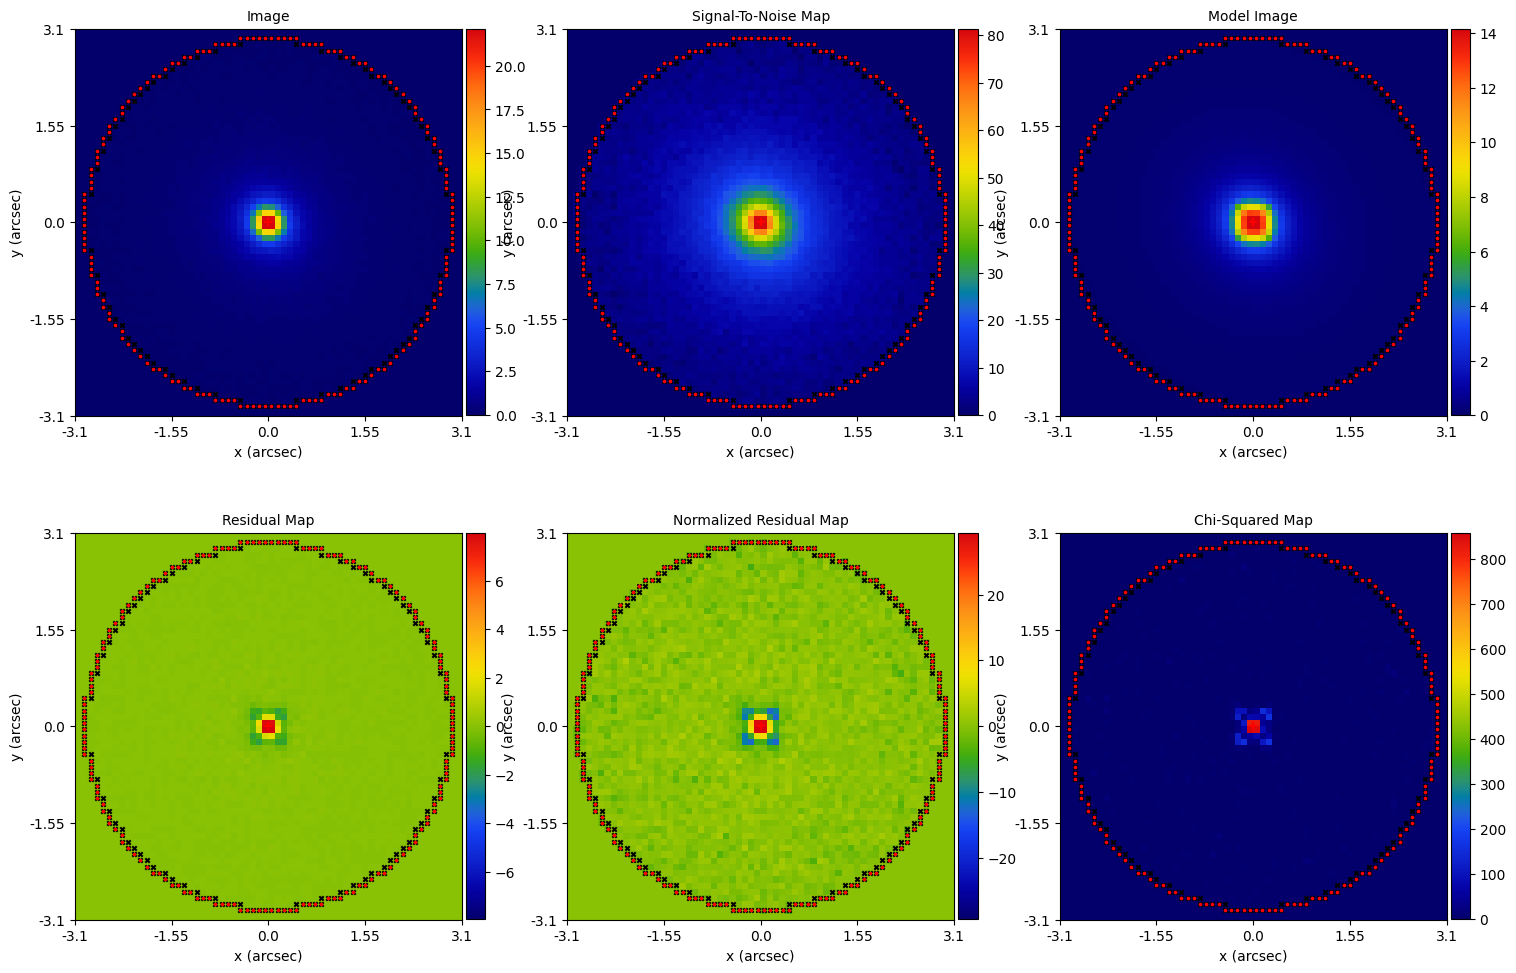

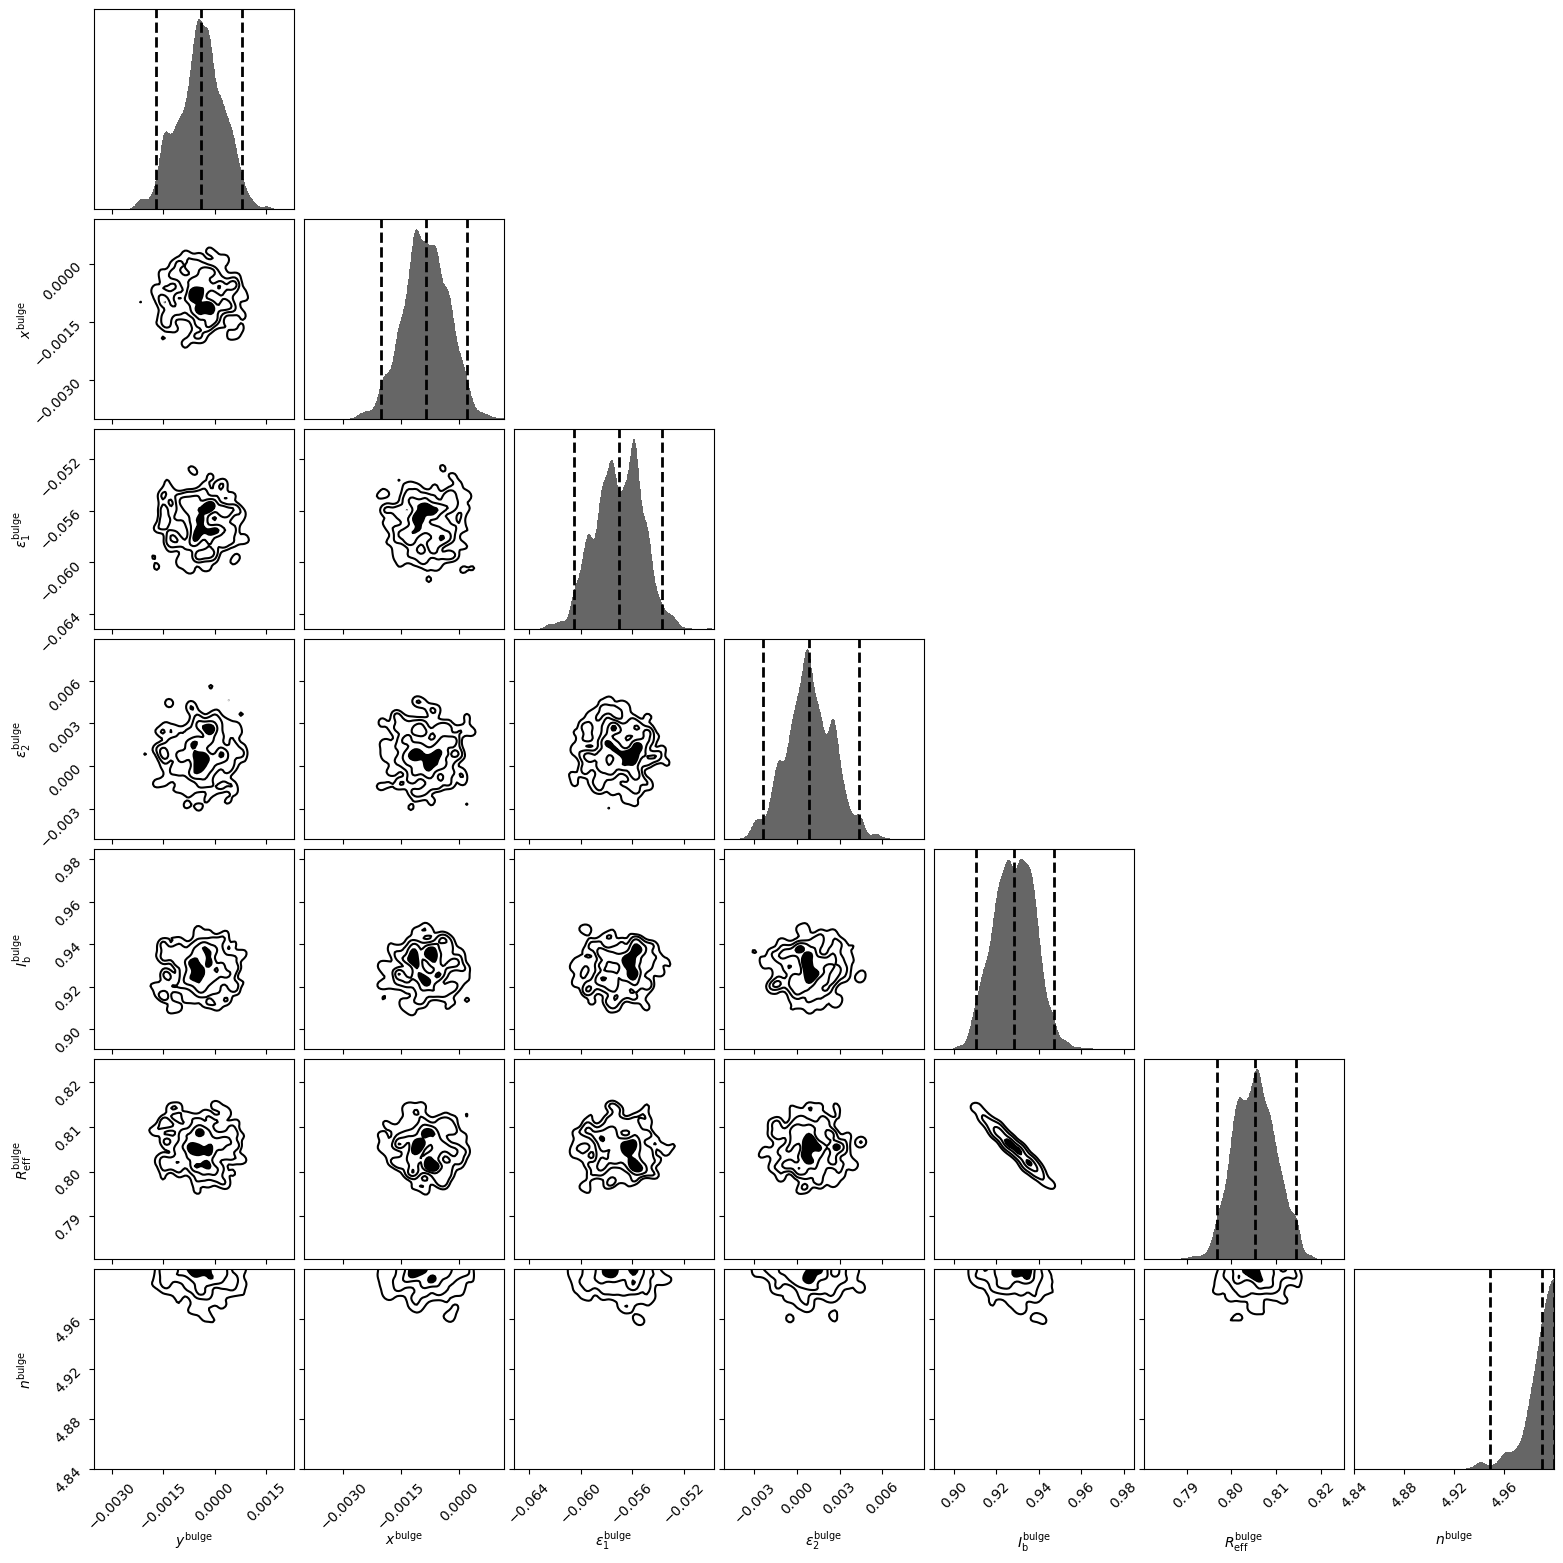

In [17]:
print(result.info)
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()


### 其它功能
- 手动设定拟合参数的prior的形式
- 模拟星系图像生成功能 ag.SimulatorImaging
- 基于pixel数据的图像重构 （惩罚项：图像的平滑）
- 多波段图像的联合拟合
- 亚像素功能

### 高级功能
- 不同成份的线性组合采用线性方程求解参数最优值  ag.lp_linear
- 采用chain的形式进行拟合：先采用简单模型拟合一些参数（比如星系中心位置），后采用复杂模型，简单拟合模型的结果可以自动传递为复杂模型的prior
    -  
- 相关图像数据的处理（UV-Plane FFT）
- 大规模数据处理的输出，支持sql数据库格式

### Comment
- 拟合过程中会有输出文件，重新拟合的时候会先查找log文件，从而实现续跑功能呢，但同时会造成问题
- 拟合结果的输出：参考pyautofit中的samples


In [19]:
samples = result.samples

samples = samples.with_paths(["galaxies.galaxy.bulge"])
samples = samples.without_paths(
    ["galaxies.galaxy.bulge.centre.centre_0",
        "galaxies.galaxy.bulge.centre.centre_1"]
)

print("Model parameters of the galaxy bulge \n")
model = samples.model
print(model.parameter_names,"\n")
#print(model.parameter_labels)
#print(model.prior_count,"parameters: \n")

fit=samples.max_log_likelihood(as_instance=False)

print("Bestfit: \n")
print(fit,"\n")
ue = samples.errors_at_upper_sigma(sigma=1.0,as_instance=False)
le = samples.errors_at_lower_sigma(sigma=1.0, as_instance=False)

print("Errors: \n")
print(ue, "\n")
print(le, "\n")


Model parameters of the galaxy bulge 

['ell_comps_0', 'ell_comps_1', 'intensity', 'effective_radius', 'sersic_index'] 

Bestfit: 

[-0.057026248166190535, 0.0006686624359132593, 0.93050433186379, 0.8044428372675, 4.99760202518713] 

Errors: 

[0.0017564986193193688, 0.0018097583539243203, 0.009757954373910027, 0.004570345993380465, 0.006528241720007877] 

[0.0020228277525578126, 0.001520084049534414, 0.010086392694791613, 0.004788124532208782, 0.012883352259650316] 

